In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Preparación de la BBDD

Importemos la base de datos y miremos sus primeras filas.

In [2]:
df = pd.read_excel('datos_g10.xlsx',
                   index_col='Nombre')
df.head().T

Nombre,FREIXENET SA,FELIX SOLIS SOCIEDAD LIMITADA,MIGUEL TORRES SA,PERNOD RICARD WINEMAKERS SPAIN SA.,"BARON DE LEY, S.A."
id,2,3,4,9,10
Código.NIF,A08018939,B13460662,A08933251,A11606118,A01129378
Número.BvD,ESA08018939,ESB13460662,ESA08933251,ESA11606118,ESA01129378
Número.BvD.-.Cuenta,ESA08018939U,ESB13460662U,ESA08933251U,ESA11606118U,ESA01129378U
Trabajadores.2022,573.0,263.0,NaN,316.0,148.0
...,...,...,...,...,...
kwstems_es_vined,2.0,26.0,307.0,15.0,4703.0
kwstems_es_visit,237.0,382.0,488.0,74.0,2000.0
kwstems_es_vist,1.0,10.0,41.0,4.0,42.0
kwstems_es_zon_de_lectur,0.0,0.0,0.0,0.0,0.0



## Creación de una tabla auxiliar

Primero **eliminemos las columnas que no aportan valor** al analisis.

In [4]:
columns_to_drop = ['Código.NIF', 
                   'Número.BvD', 
                   'Número.BvD.-.Cuenta', 
                   'Número.BvD.-.Cuenta.y', 
                   'urls_nuevas', 
                   'date', 
                   'sizehtml', 
                   'sizetext', 
                   'País',
                   'Código.consolidación',
                   'Ultimo.año.disponible',
                   'website',
                   'URL']

for column in columns_to_drop:
    df.drop(column, axis=1, inplace=True, errors='ignore')

Luego **cambiemos los nombres de columnas** para mayor comodidad del analisis.

In [5]:
columns_to_rename = {'Trabajadores':'EMP',
                    'Total.Activo':'TA',
                    'tamaño':'TAM',
                    'ROE(%)':'ROE', 'ROA(%)':'ROA',
                    'Valor.agregado':'VA',
                    'Ingresos.de.explotación.por.empleado(mil)':'IEPE',
                    'Ingresos.de.explotación':'IE',
                    'Resultado.del.Ejercicio':'RE',
                    'Valor.Agregado.por.Empleado':'VAE',
                    'Cuota.Mercado.Explotacion':'CM'
                   }

# renaming the economy columns one by one
for column in df.columns:
    first, *other = column.rsplit('.', 1)

    if first in columns_to_rename:
        df = df.rename(columns={column: columns_to_rename[first] + '.' + other[0]})

**Creemos una tabla auxiliar** con tres columnas:
+ nombre de variable de la BBDD original
+ tipo de variable (numerica, categorica, binaria)
+ bloque a que pertenece la variable (datos economicos, datos de webscraping, datos identificativos)

In [6]:
# creating auxiliary table for the main dataframe

allColumns = list(df.columns)

type = pd.Series(['numerical']*9 + 
                 ['categorical']*4 +
                 ['numerical']*32 +
                 ['categorical'] +
                 ['binary'] + 
                 ['numerical']*206, name='Type')

variable = pd.Series(allColumns, name='Variable')

block = pd.Series(['identity'] +
                  ['economical']*44 +
                  ['identity'] +
                  ['other'] +
                  ['webscraping']*206, name='Block')

aux = pd.concat([variable, type, block], axis=1)

numerical = aux.loc[aux['Type'] == 'numerical', 'Variable']
categorical = aux.loc[aux['Type'] == 'categorical', 'Variable']
binary = aux.loc[aux['Type'] == 'binary', 'Variable']

aux = aux.set_index('Variable')
aux

,Type,Block
Variable,,
id,numerical,identity
EMP.2022,numerical,economical
EMP.2021,numerical,economical
EMP.2020,numerical,economical
EMP.2019,numerical,economical
...,...,...
kwstems_es_vined,numerical,webscraping
kwstems_es_visit,numerical,webscraping
kwstems_es_vist,numerical,webscraping


**Hagamos un recuento de variables por tipo** y lo comprobemos con los tipos de datos del dataframe.

In [7]:
aux['Type'].value_counts()

Type
numerical      247
categorical      5
binary           1
Name: count, dtype: int64

In [8]:
df.dtypes.value_counts()

float64    243
object       9
int64        1
Name: count, dtype: int64

La libreria que usamos para manejar los datos hace su mejor trabajo para adivinar el tipo de variables presentes en los datos importados. Y aun asi de hecho en el dataframe tenemos 4 variables de tipo object mas que deberiamos. Normalmente esto sucede cuando una variable aparte de los datos numericos contiene datos de otros tipos.

Comprobemos cuales son aquellas 4 variables y miremos que datos contienen.

In [10]:
aux.loc[aux['Type'] == 'categorical', :].index

Index(['TAM.2022', 'TAM.2021', 'TAM.2020', 'TAM.2019', 'Localidad'], dtype='object', name='Variable')

Y ahora veamos que variables tienen el tipo de object.

In [11]:
df.dtypes[df.dtypes == object]

TAM.2022     object
TAM.2021     object
TAM.2020     object
TAM.2019     object
IEPE.2022    object
IEPE.2021    object
IEPE.2020    object
IEPE.2019    object
Localidad    object
dtype: object

Esta claro que las columnas de la variable IEPE contienen otros datos aparte de datos numericos. Miremos los valores de estas variables.

In [12]:
df['IEPE.2019'].value_counts().head()

IEPE.2019
n.s.          388
0               6
27.753265       1
707.355377      1
176.33043       1
Name: count, dtype: int64

In [13]:
df['IEPE.2020'].value_counts().head()

IEPE.2020
n.s.          386
0              12
246.536161      1
9.8444          1
3.4874          1
Name: count, dtype: int64

In [14]:
df['IEPE.2021'].value_counts().head()

IEPE.2021
n.s.          365
0               3
827.15487       1
662.698961      1
334.055238      1
Name: count, dtype: int64

In [15]:
df['IEPE.2022'].value_counts().head()

IEPE.2022
n.s.        266
0             2
6.842723      1
18.87029      1
18.60354      1
Name: count, dtype: int64

Se ve que entre los valores numericos hay un grupo de orservaciones con el valor de 'n.s.'.
Sustituyamos estos valores por NaN antes de proceder con el analisis.

In [16]:
df.loc[:, df.columns.str.contains('IEPE')].isna().sum()

IEPE.2022    682
IEPE.2021    361
IEPE.2020    303
IEPE.2019    291
dtype: int64

In [17]:
columns_to_check = df.columns[df.columns.str.contains('IEPE')]

for column in columns_to_check:
    df.loc[df[column] == 'n.s.', column] = np.nan

In [18]:
df.loc[:, df.columns.str.contains('IEPE')].isna().sum()

IEPE.2022    948
IEPE.2021    726
IEPE.2020    689
IEPE.2019    679
dtype: int64

Ahora podemos convertir las variables al tipo numerico.

In [19]:
df[columns_to_check] = df.loc[:, columns_to_check].astype(np.float64)
df.dtypes.value_counts()

float64    247
object       5
int64        1
Name: count, dtype: int64

## Análisis de variables por tipo 
### Variables binarias

La unica variable binaria es bastante equilibrada en sus valores por lo que de momento la dejamos intacta.

In [20]:
df.loc[:, binary].value_counts(normalize=True)

enotourism
0.0           0.562543
1.0           0.437457
Name: proportion, dtype: float64

### Variables numericas

Hay dos grupos grandes de las variables numericas: las variables economicas y las variables procedentes de webscraping.

Datos en cada de dos grupos a lo mejor fueron grabados de maneras distintas. Por eso, analizemos los grupos por separado.

In [21]:
numerical_economical = aux.query('Type == "numerical" & Block == "economical"').index

numerical_webscraping = aux.query('Type == "numerical" & Block == "webscraping"').index

De todas las variables solo la de cuota de mercado presenta los valores de desviacion tipica cercana a cero. Esto se justifica por el rango de datos siendo un intervalo entre 0 y 1. Por lo tanto, dejamos las variables sin cambios.

In [22]:
df.loc[:, numerical_economical].describe().loc['std', :]

Variable
EMP.2022     2.722834e+01
EMP.2021     2.645475e+01
EMP.2020     2.723503e+01
EMP.2019     2.784449e+01
TA.2022      2.443419e+01
TA.2021      2.249963e+01
TA.2020      2.147925e+01
TA.2019      2.073638e+01
ROE.2022     1.991334e+02
ROE.2021     2.130904e+02
ROE.2020     8.024643e+02
ROE.2019     5.570299e+02
ROA.2022     1.057166e+01
ROA.2021     3.534456e+01
ROA.2020     2.749678e+01
ROA.2019     7.530262e+05
VA.2022      3.148460e+06
VA.2021      2.638928e+06
VA.2020      3.296221e+06
VA.2019      2.553173e+06
IEPE.2022    2.409387e+02
IEPE.2021    2.368568e+02
IEPE.2020    7.776553e+02
IEPE.2019    2.731250e+02
IE.2022      1.249030e+07
IE.2021      1.112299e+07
IE.2020      1.002698e+07
IE.2019      1.022631e+07
RE.2022      1.426144e+06
RE.2021      1.049482e+06
RE.2020      2.542910e+06
RE.2019      1.134089e+06
VAE.2022     1.230850e+05
VAE.2021     1.557783e+05
VAE.2020     7.075075e+05
VAE.2019     1.282929e+05
CM.2022      2.040053e-03
CM.2021      1.804909e-03
CM.

Dado el numero grande de las variables de webscraping, analizemos las caracteristicas descriptivas de la misma desviacion tipica. De aqui se ve que hay variables con desviacion tipica igual a 0 (valor minimo de 0 en las estadisticas descriptivas).


In [23]:
std = df.loc[:, numerical_webscraping].describe().loc['std', :].describe()
std

count     206.000000
mean      101.215833
std       224.800855
min         0.000000
25%         4.314260
50%        22.966737
75%        72.938223
max      1523.743588
Name: std, dtype: float64

Busquemos estas variables y las eliminemos de la base.

In [24]:
columns_to_drop = df.loc[:, numerical_webscraping].std()[df.loc[:, numerical_webscraping].std() == 0].index
list(columns_to_drop)

['keywords_enohuesped', 'keywords_enovisitante', 'kwstems_es_enohuesp']

In [25]:
df = df.drop(columns_to_drop, axis=1)
aux = aux.drop(columns_to_drop)

### Variables categoricas

Hay 4 variables categoricas economicas y 1 variable categorica de identidad. Empecemos con las variables economicas.

In [26]:
categorical_economical = aux.query('Type == "categorical" & Block == "economical"').index

df.loc[:, categorical_economical].apply(pd.Series.value_counts, axis=0)

Variable,TAM.2022,TAM.2021,TAM.2020,TAM.2019
Micro,1022,1290,1358,1362
Pequeña,312,379,383,410
Mediana,53,70,73,77
Grande,8,9,13,11


Se ve que hay menos empresas de tamano grande pero no existen categorias ni vacias ni redundantes.

Ahora veamos como es la unica variable categorica de identidad.

Esperadamente en algunas localidades hay mas bodegas que en otras. Esta informacion puede  resultar util para el analisis posterior.

In [27]:
df['Localidad'].value_counts()

Localidad
MADRID                  73
LAGUARDIA               39
SANT SADURNI D'ANOIA    32
JUMILLA                 27
JEREZ DE LA FRONTERA    26
                        ..
CAPÇANES                 1
ALMERIA                  1
LA ROCA DEL VALLES       1
MONTCADA I REIXAC        1
CACERES                  1
Name: count, Length: 810, dtype: int64

## Análisis de valores faltantes por variable


In [28]:
aux.groupby('Block')['Type'].value_counts()

Block        Type       
economical   numerical       40
             categorical      4
identity     categorical      1
             numerical        1
other        binary           1
webscraping  numerical      203
Name: count, dtype: int64

In [29]:
aux.groupby('Type')['Block'].value_counts()

Type         Block      
binary       other            1
categorical  economical       4
             identity         1
numerical    webscraping    203
             economical      40
             identity         1
Name: count, dtype: int64

Primero miremos a una grafica con la base de datos entera para explorar de manera visual si se reconoce alguna pauta de valores faltantes.

Aparentemente tenemos dos grupos grandes de variables que se comportan diferentemente en terminos de los datos faltantes.

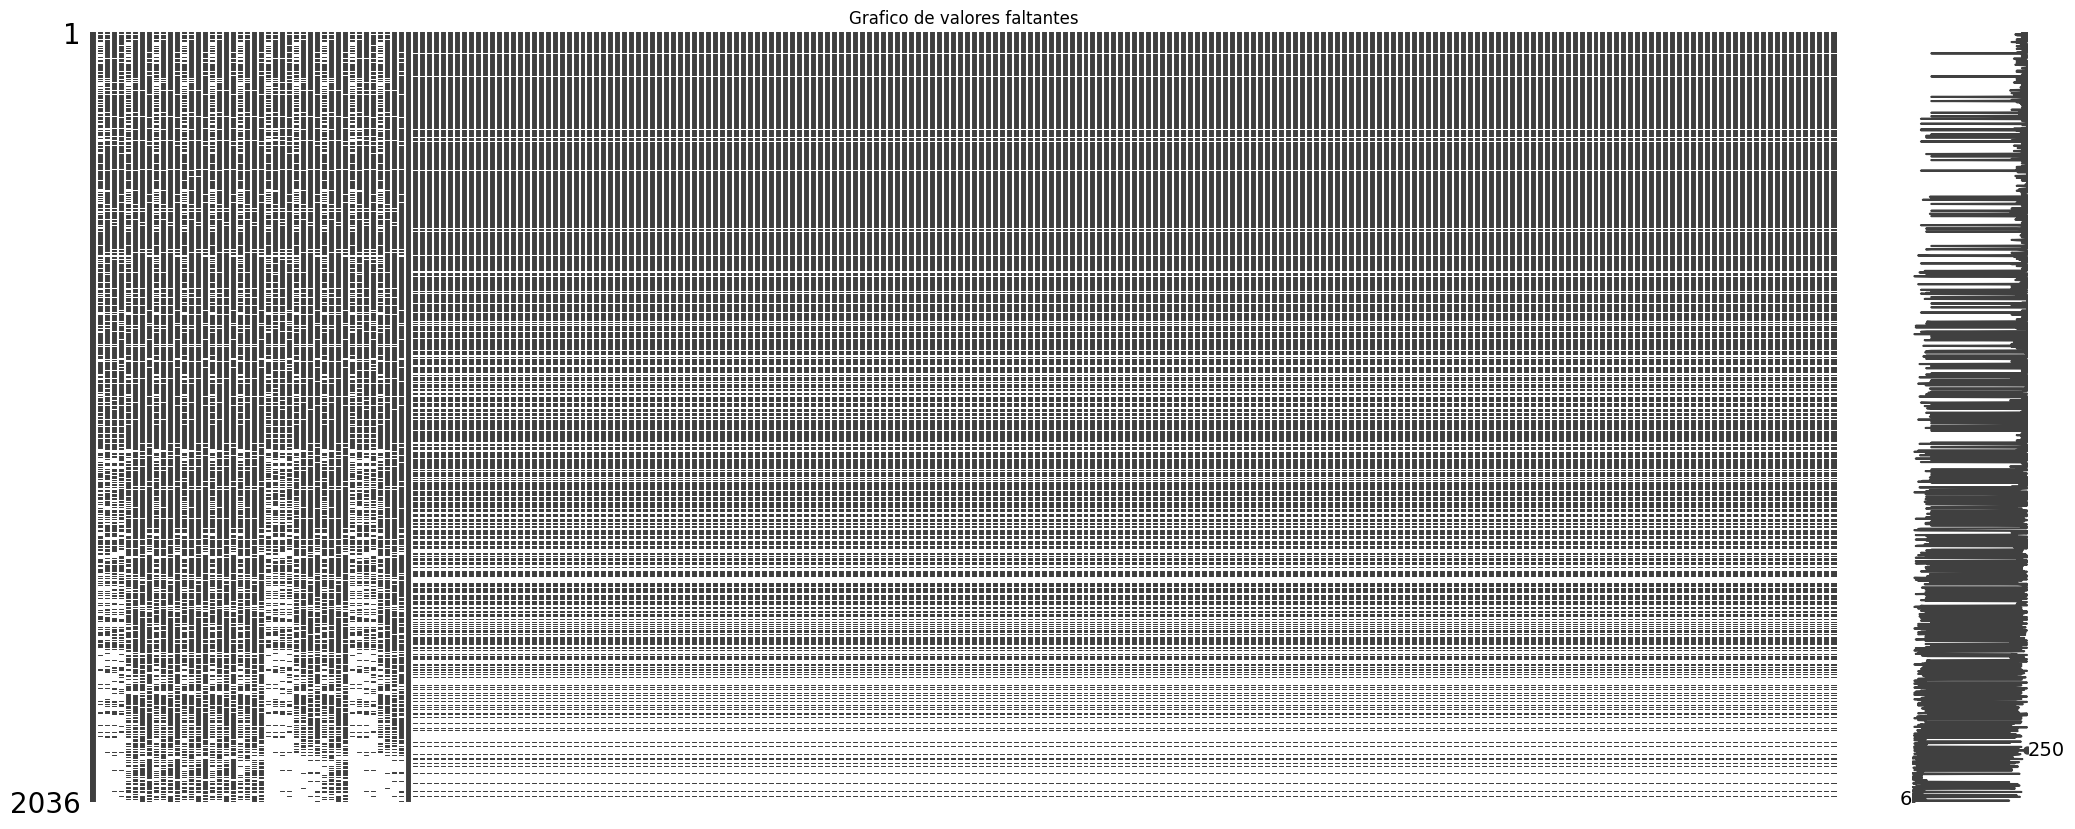

In [30]:
msno.matrix(df)
plt.title("Grafico de valores faltantes")
plt.show()

Miremos con mas detalle primero las variables numericas, binarias y categoricas por separado.

### Variables numericas

En nuestra base de datos hay 2 grupos de variables numericas: las economicas y las de recuentos de palabras clave.
Hagamos un estudio de las variables de cada grupo de variables primero por variable y luego por observacion.

#### Variables numericas economicas

Primero de todo, miremos la pauta de valores faltantes an las variables numericas economicas.
De la grafica se ve que las variables siguen una u otra pauta de valores faltantes en función del año al que corresponden.
Además, algunas variables tienden tener mas valores faltantes que otras. Por ejemplo, las variables EMP y VAE frente a las demas variables.

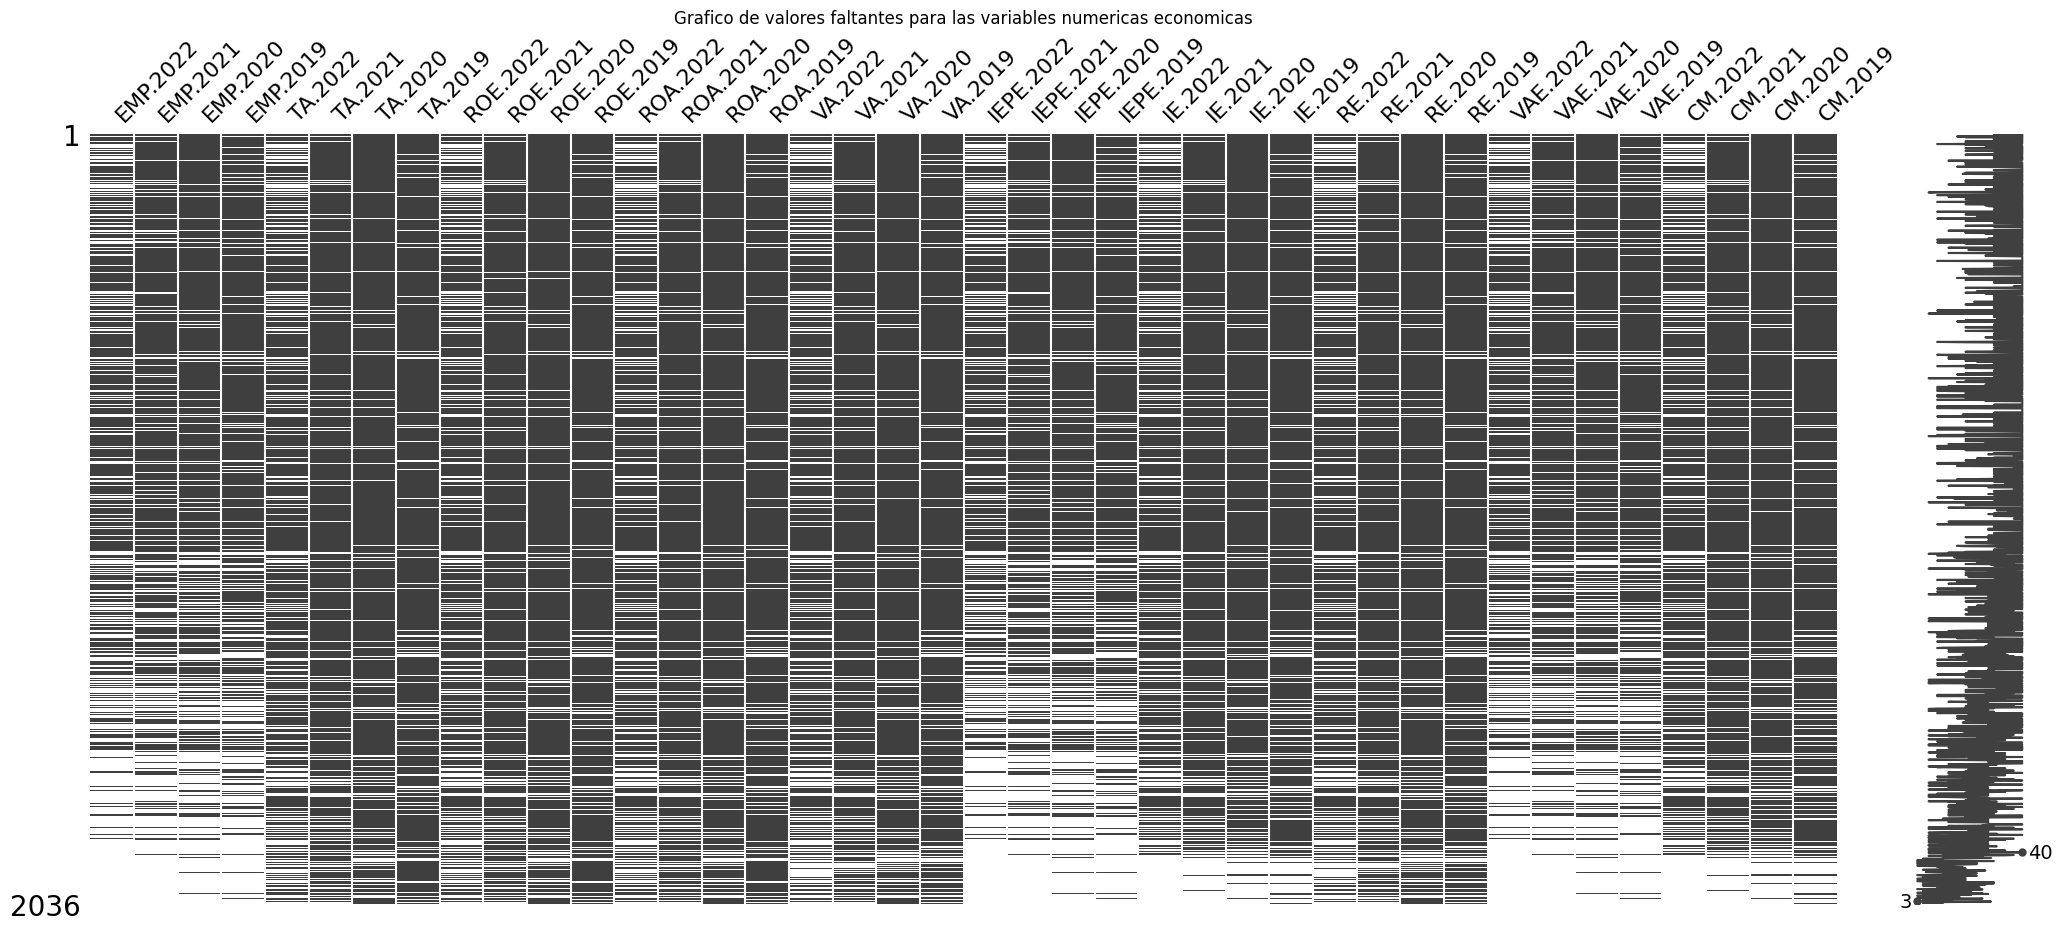

In [31]:
msno.matrix(df.loc[:, numerical_economical])
plt.title("Grafico de valores faltantes para las variables numericas economicas")
plt.show()

Para analizar la situacion con mayor detalle, miremos a las estadisticas descriptivas.

Son evidentes dos cosas: 
1) nos faltan datos del numero de trabajadores para mas de la mitad de bodegas y, por tanto, tenemos las variables que se calculan en funcion del numero de empleados EMP y VAE con mas de 50 porcien de valores faltantes,
2) si en los años 2019-2021 tenemos un porcentaje de datos faltantes de 25 o menos por ciento, para el año 2022 todas las variables superan el umbral de 50 por ciento. 

Entonces, se decide eliminar las variables dependientes del numero de empleados y las variables para el año 2022.

In [32]:
def get_na_count(s):
    return s.isna().sum()

def get_na_percentage(s):
    return s.isna().mean()

def get_na_table(df, axis=0):
    na_count = df.apply(get_na_count, axis=axis)
    na_percentage = df.apply(get_na_percentage, axis=axis)
    
    return (pd.concat([na_count, na_percentage], axis=1).rename(columns={0:'Count', 1:'Percentage'}))

numerical_economical = aux.query('Type == "numerical" & Block == "economical"').index

In [33]:
numerical_economical_na_table = get_na_table(df.loc[:, numerical_economical])
numerical_economical_na_table.sort_values(by='Percentage', ascending=False)

,Count,Percentage
Variable,,
EMP.2022,948,0.465619
IEPE.2022,948,0.465619
VAE.2022,948,0.465619
EMP.2021,726,0.356582
IEPE.2021,726,0.356582
VAE.2021,726,0.356582
EMP.2020,689,0.338409
IEPE.2020,689,0.338409
VAE.2020,689,0.338409


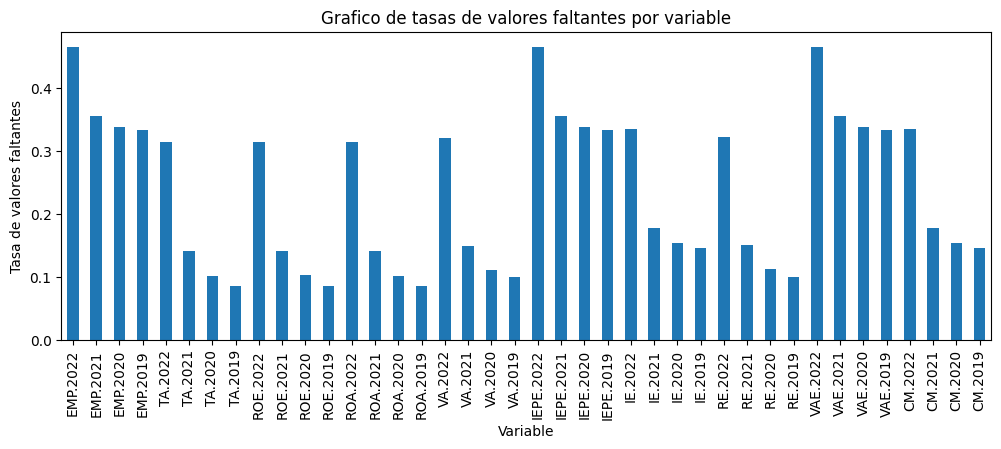

In [34]:
plt.figure(figsize=(12,4))
numerical_economical_na_table['Percentage'].plot(kind='bar')
plt.title("Grafico de tasas de valores faltantes por variable")
plt.xlabel("Variable")
plt.ylabel("Tasa de valores faltantes")
plt.show()

In [35]:
variables_to_leave = (df.columns.str.contains('2022|EMP|VAE|IEPE') == False)

df = df.loc[:, variables_to_leave]
aux = aux.loc[variables_to_leave, :]


Al comprobar de nuevo vemos que ninguna de las variables tiene mas de 20% de valores faltantes.

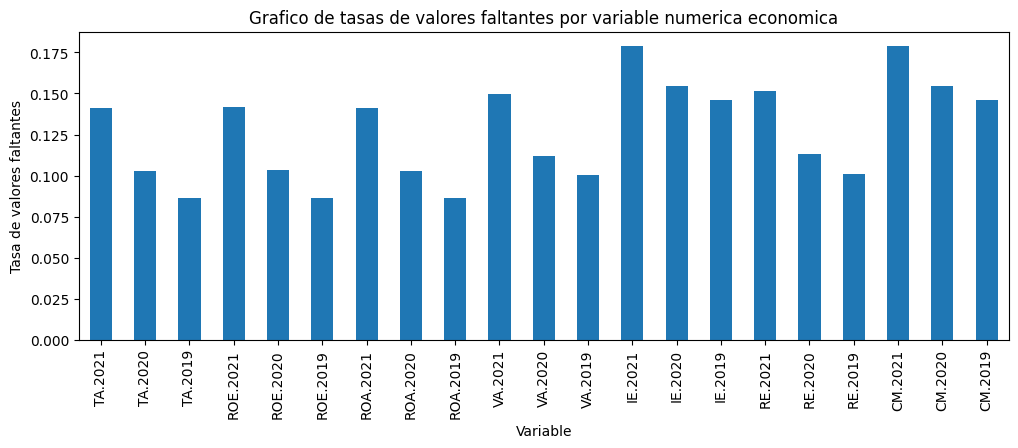

In [36]:
plt.figure(figsize=(12,4))
numerical_economical = aux.query('Type == "numerical" & Block == "economical"').index

numerical_economical_na_percentage = df.loc[:, numerical_economical].apply(get_na_percentage, axis=0)
numerical_economical_na_percentage.plot(kind='bar')

plt.title("Grafico de tasas de valores faltantes por variable numerica economica")
plt.xlabel("Variable")
plt.ylabel("Tasa de valores faltantes")
plt.show()

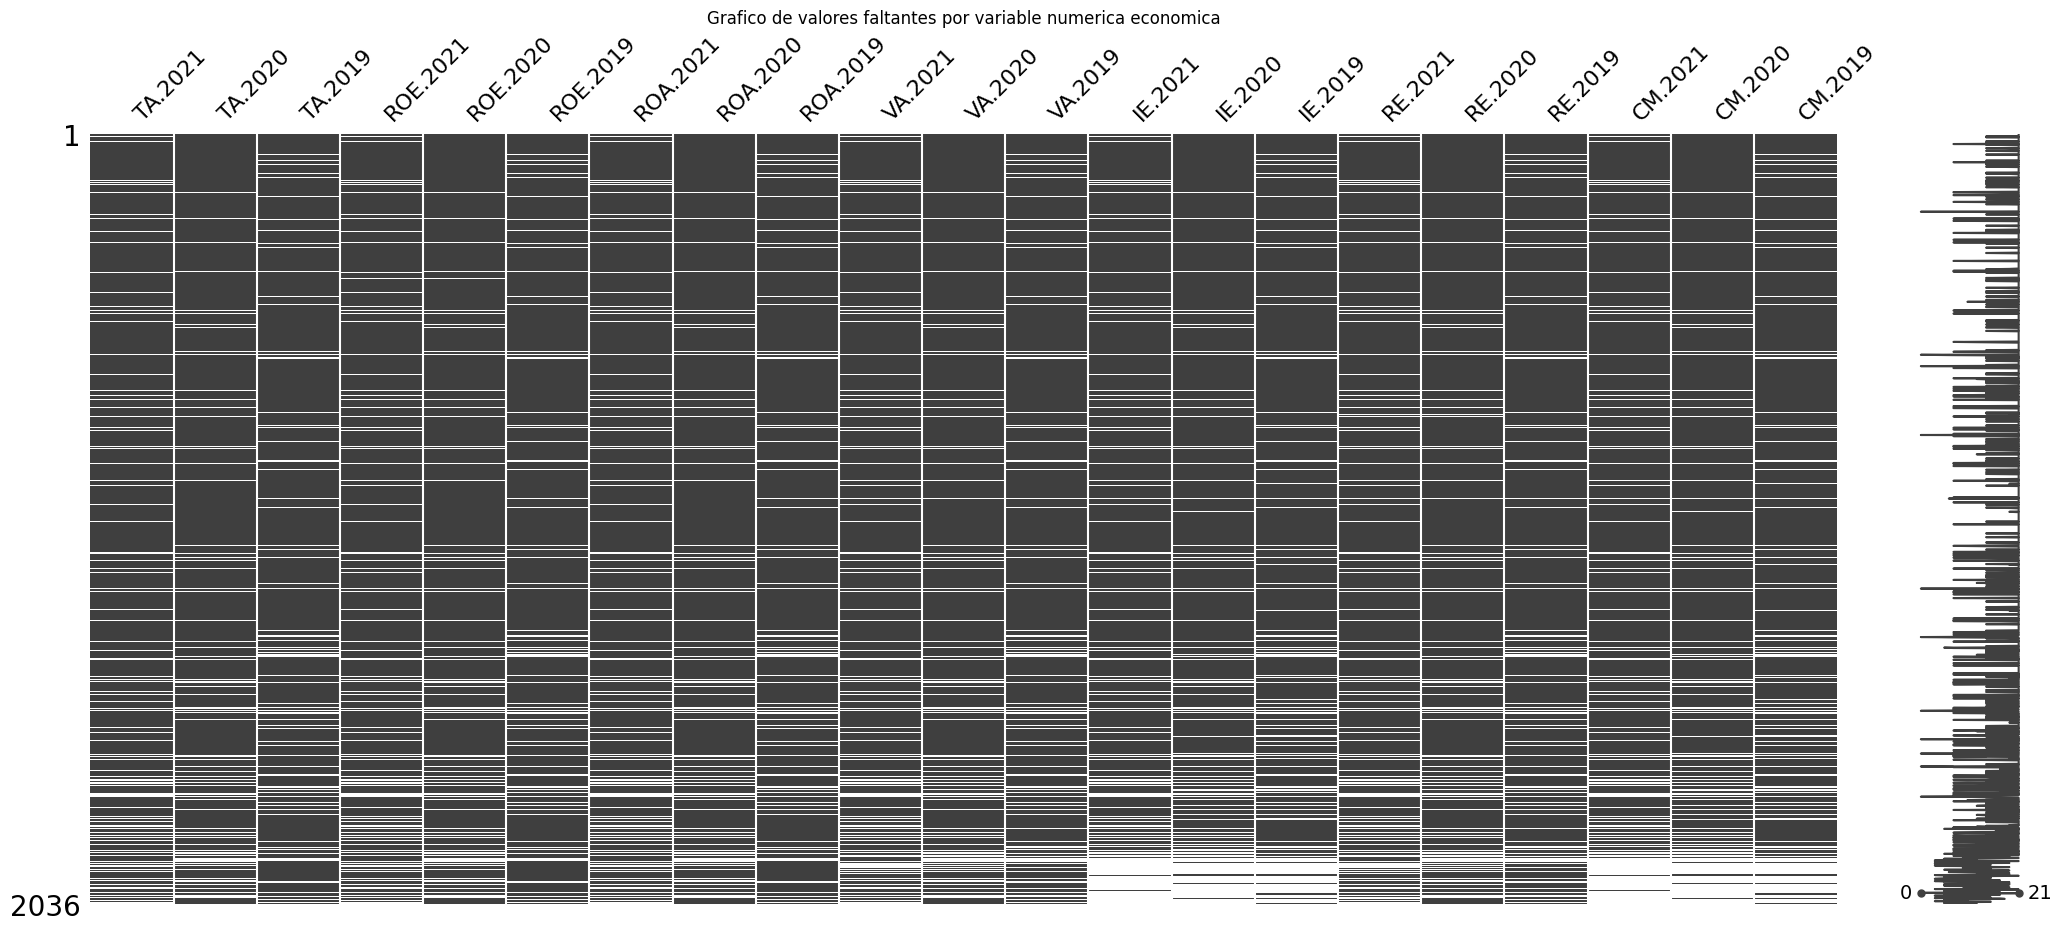

In [37]:
msno.matrix(df.loc[:, numerical_economical])
plt.title("Grafico de valores faltantes por variable numerica economica")
plt.show()

#### Variables numericas procedentes de webscraping

Los datos de webscraping son resultado de un procedimiento automatico y, por tanto, sus pautas de valores faltantes son diferentes. A lo mejor, en algun sitio web no se permite webscraping o no era disponible en el momento de la recogida de datos.

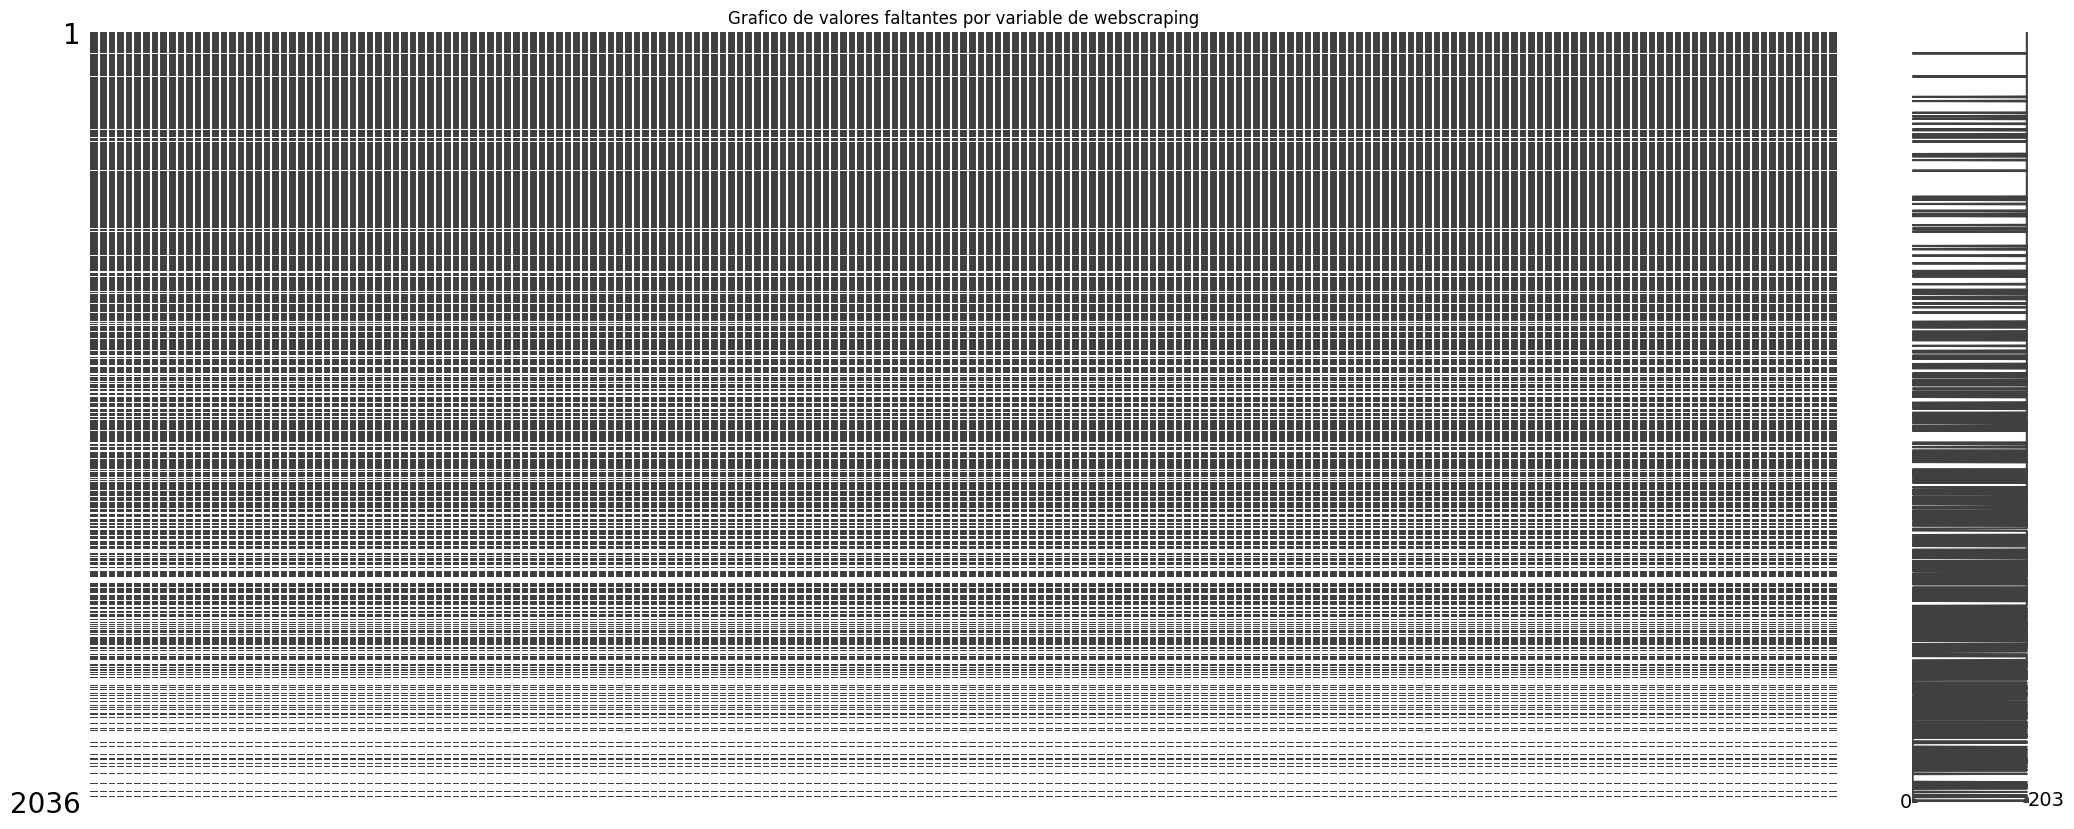

In [38]:
numerical_webscraping = aux.query('Type == "numerical" & Block == "webscraping"').index
msno.matrix(df.loc[:, numerical_webscraping])

plt.title("Grafico de valores faltantes por variable de webscraping")
plt.show()

El analisis de estadisticas descriptivas nos confirma esta observacion: tenemos 28% de observaciones con datos faltantes en cada de estas variables.

In [39]:
numerical_webscraping = aux.query('Type == "numerical" & Block == "webscraping"').index

numerical_webscraping_na_table = get_na_table(df.loc[:, numerical_webscraping])
numerical_webscraping_na_table.sort_values(by='Percentage', ascending=False)

,Count,Percentage
Variable,,
keywords_actividades,573,0.281434
keywords_agradable,573,0.281434
keywords_alojamiento,573,0.281434
keywords_alquiler,573,0.281434
keywords_bano,573,0.281434
...,...,...
kwstems_es_vined,573,0.281434
kwstems_es_visit,573,0.281434
kwstems_es_vist,573,0.281434


### Variables binarias

Vemos que la unica variable binaria tiene la mayoria de los valores presentes (72%) y un 28% de valores faltantes.

A pesar de una tasa de valores faltantes elevada, dejaria la variable en su lugar por que nos puede servir como variable respuesta para el analisis posterior.

In [40]:
df.loc[:, binary].isna().sum() / df.shape[0]

enotourism    0.281434
dtype: float64

### Variables categoricas

#### Variables categoricas economicas

Todas las 3 variables categoricas economicas restantes tienen una tasa de valores faltantes por debajo de 25%.

In [41]:
categorical_economical = aux.query('Type == "categorical" & Block == "economical"').index
get_na_table(df.loc[:, categorical_economical], axis=0)

,Count,Percentage
Variable,,
TAM.2021,288,0.141454
TAM.2020,209,0.102652
TAM.2019,176,0.086444


#### Variables categoricas de identidad

Solo a una observacion le faltan datos en la variable de Localidad.

In [42]:
categorical_identity = aux.query('Type == "categorical" & Block == "identity"').index
get_na_table(df.loc[:, categorical_identity], axis=0)

,Count,Percentage
Variable,,
Localidad,1,0.000491


In [43]:
df.loc[df['Localidad'].isna(), :]

,id,TA.2021,TA.2020,TA.2019,TAM.2021,TAM.2020,TAM.2019,ROE.2021,ROE.2020,ROE.2019,...,kwstems_es_tempor,kwstems_es_terraz,kwstems_es_tour,kwstems_es_turism,kwstems_es_vendimi,kwstems_es_vined,kwstems_es_visit,kwstems_es_vist,kwstems_es_zon_de_lectur,kwstems_es_zon_comun
Nombre,,,,,,,,,,,,,,,,,,,,,
BODEGA ARANLEON SL.,1122,NaN,2.973692,2.958013,NaN,Micro,Micro,NaN,0.277,0.497,...,0.0,0.0,0.0,0.0,27.0,52.0,3.0,0.0,0.0,0.0


Tras buscar la informacion sobre la bodega en cuestion, encontramos que es una empresa de Valencia. Rellenemos la localidad para ella y comprobemos que despues de esto no nos faltan mas datos.

In [44]:
df.loc['BODEGA ARANLEON SL.','Localidad'] = 'Valencia'

get_na_table(df.loc[:, categorical_identity], axis=0)

,Count,Percentage
Variable,,
Localidad,0,0.0


## Análisis de valores faltantes por observacion


Explorando valores faltantes por observacion, vemos que las observaciones con mas de 25% de valores faltantes son aquellas a cuales le fantan datos de webscraping. Por tanto, eliminamos estas observaciones.

In [45]:
na_by_observation = df.apply(get_na_percentage, axis=1).value_counts().sort_index()
na_by_observation

0.000000    1165
0.008696      17
0.013043       1
0.017391       6
0.026087       7
0.034783     161
0.043478       5
0.052174       8
0.069565      77
0.078261       6
0.086957       2
0.104348       8
0.886957     302
0.895652      25
0.904348       8
0.908696       1
0.913043      20
0.921739      74
0.930435      19
0.939130      20
0.947826       1
0.956522      63
0.965217      25
0.973913      11
0.991304       4
Name: count, dtype: int64

In [46]:
pd.DataFrame({'< 25%':pd.Series(na_by_observation[na_by_observation.index < 0.25].sum()),
              '>= 25%':pd.Series(na_by_observation[na_by_observation.index >= 0.25].sum())})

,< 25%,>= 25%
0,1463,573


In [47]:
df = df[df.apply(get_na_percentage, axis=1) < 0.25]
df.shape

(1463, 230)

Miremos ahora a nuestra base despues de eliminar las variables y observaciones con el numero elevado de valores faltantes.

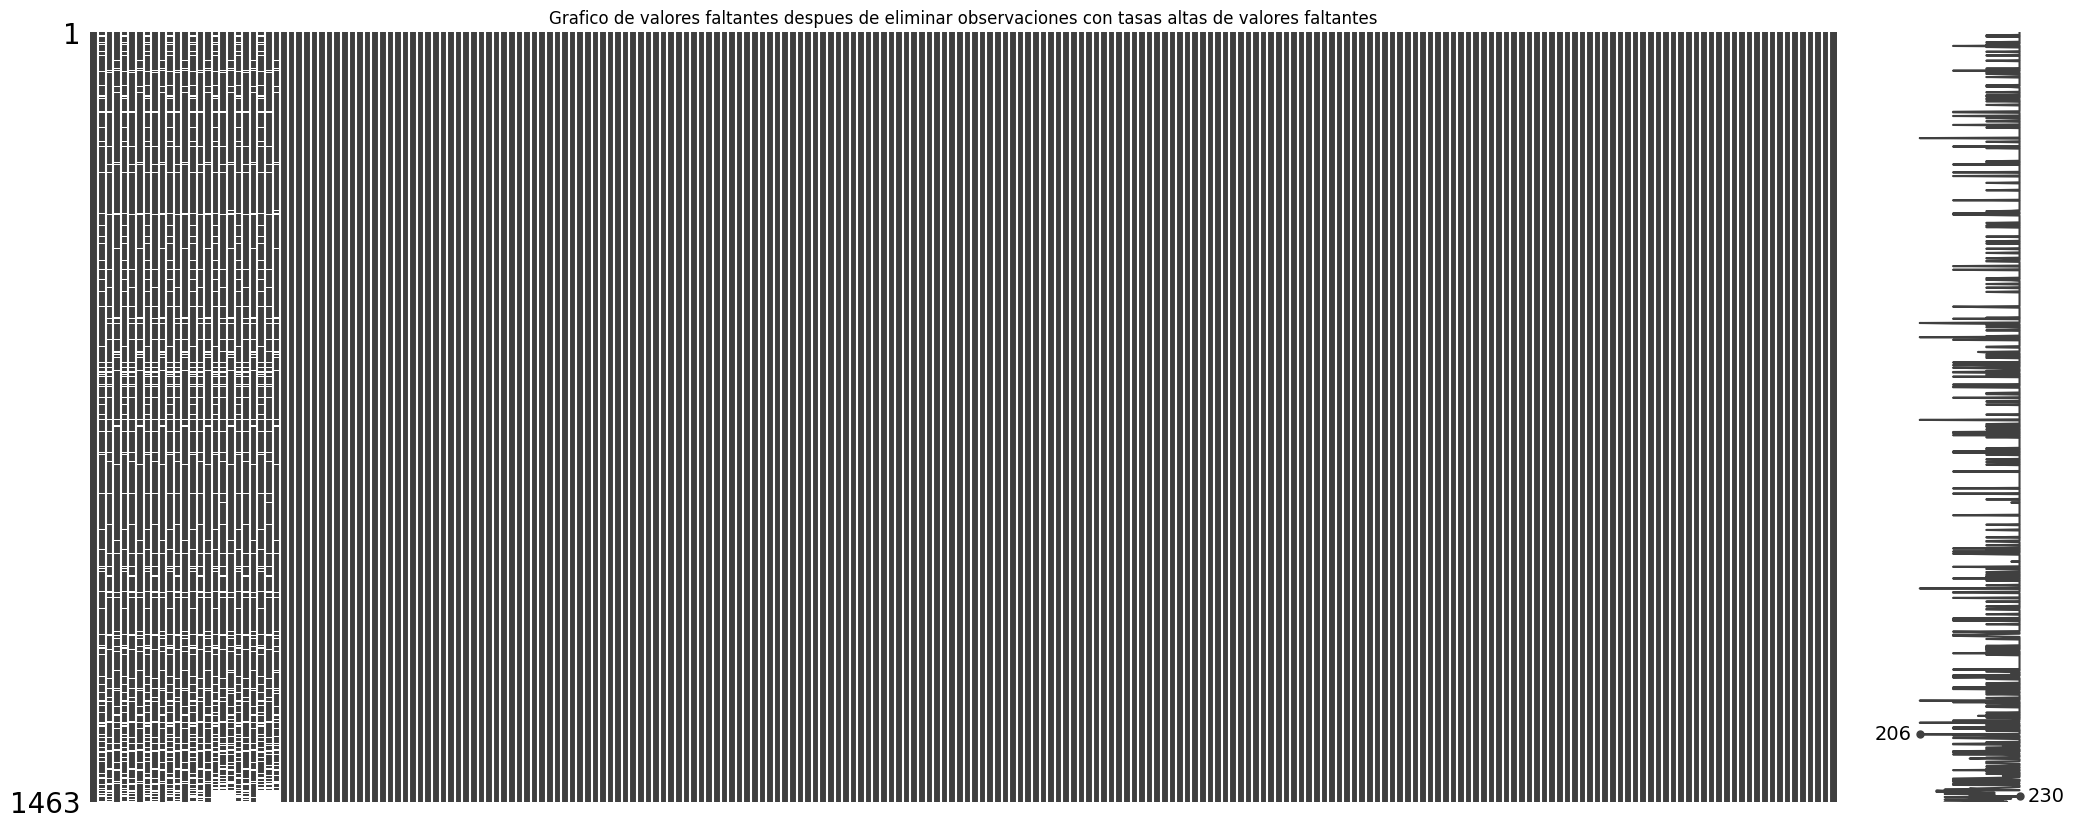

In [48]:
msno.matrix(df)
plt.title("Grafico de valores faltantes despues de eliminar observaciones con tasas altas de valores faltantes")
plt.show()

In [49]:
df['enotourism'].value_counts()

enotourism
0.0    823
1.0    640
Name: count, dtype: int64

## Imputacion de valores faltantes

Antes de imputar los valores, hay que recodificar y convertir las tres variables categoricas en formato numerico.

In [50]:
values_to_recode = {'Micro':0,
                    'Pequeña':1,
                    'Mediana':2,
                    'Grande':3}

df[categorical_economical] = df[categorical_economical].apply(lambda x: x.map(values_to_recode))
df[categorical_economical]

,TAM.2021,TAM.2020,TAM.2019
Nombre,,,
FREIXENET SA,3.0,3.0,3.0
FELIX SOLIS SOCIEDAD LIMITADA,3.0,3.0,3.0
MIGUEL TORRES SA,3.0,3.0,3.0
PERNOD RICARD WINEMAKERS SPAIN SA.,3.0,3.0,3.0
"BARON DE LEY, S.A.",3.0,3.0,3.0
...,...,...,...
"MONTAÑA CLARA, SA",0.0,NaN,0.0
REAL JUNTA SA,0.0,0.0,0.0
VIÑA ALMUDENA SL,0.0,0.0,0.0


In [51]:
from sklearn.impute import KNNImputer

columns_to_impute = list(numerical_economical) + list(categorical_economical)          

df_original = df.loc[:, columns_to_impute]

# Impute missing values using KNN with k=3 neighbors and median strategy
imputer = KNNImputer(n_neighbors=3, weights='uniform')  # You can adjust weights and neighbors
imputer.fit(df_original)
df_imputed = imputer.transform(df_original)
df_imputed = pd.DataFrame(df_imputed, columns=columns_to_impute, index=df_original.index) 

In [52]:
df_imputed_final = df.copy()

df_imputed_final.loc[:, columns_to_impute] = df_imputed
#df_imputed_final = df_imputed_final.loc[:, ~df_imputed_final.columns.isin(categorical_economical)]

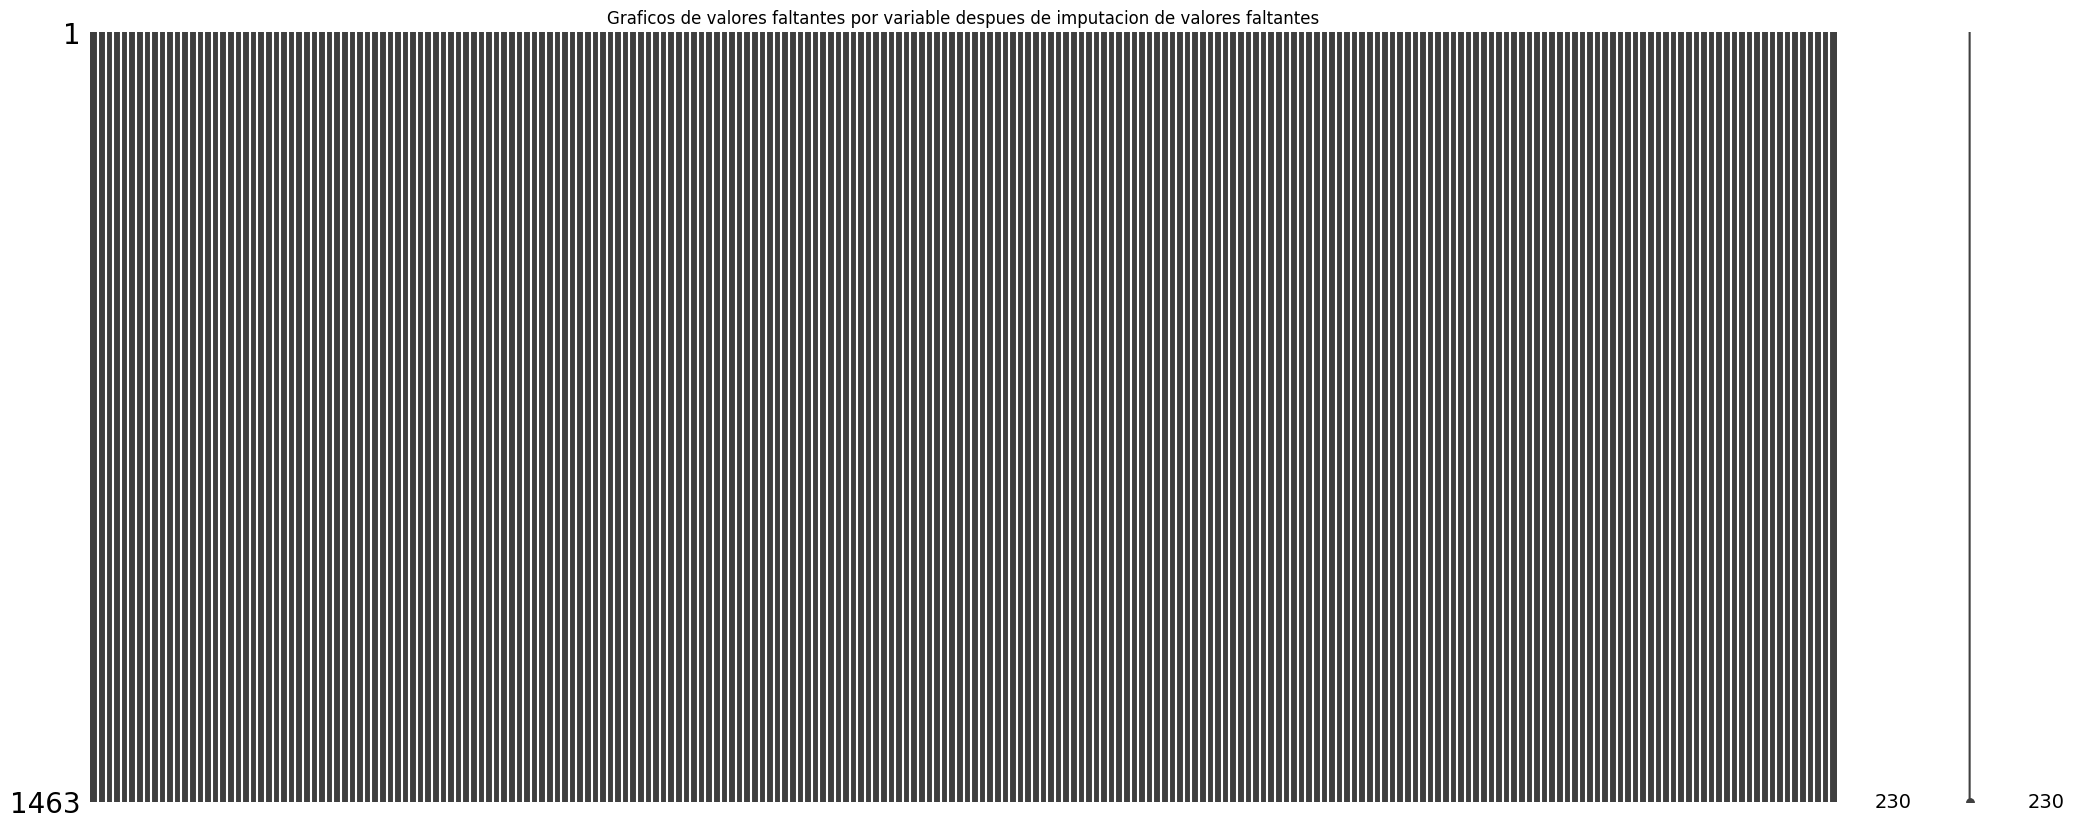

In [53]:
msno.matrix(df_imputed_final)
plt.title("Graficos de valores faltantes por variable despues de imputacion de valores faltantes")
plt.show()

Ahora comprobemos las distribuciones de variables con graficas de caja y bigotes. 

In [54]:
# Melt the dataframes to long format for boxplot
df_original_melted = df_original.loc[:, columns_to_impute].melt(var_name='Variable', value_name='Value')
df_original_melted['Condition'] = 'Original'

df_imputed_melted = df_imputed_final.loc[:, columns_to_impute].melt(var_name='Variable', value_name='Value')
df_imputed_melted['Condition'] = 'Imputed'

# Combine data
combined_data = pd.concat([df_original_melted, df_imputed_melted], axis=0).reset_index()

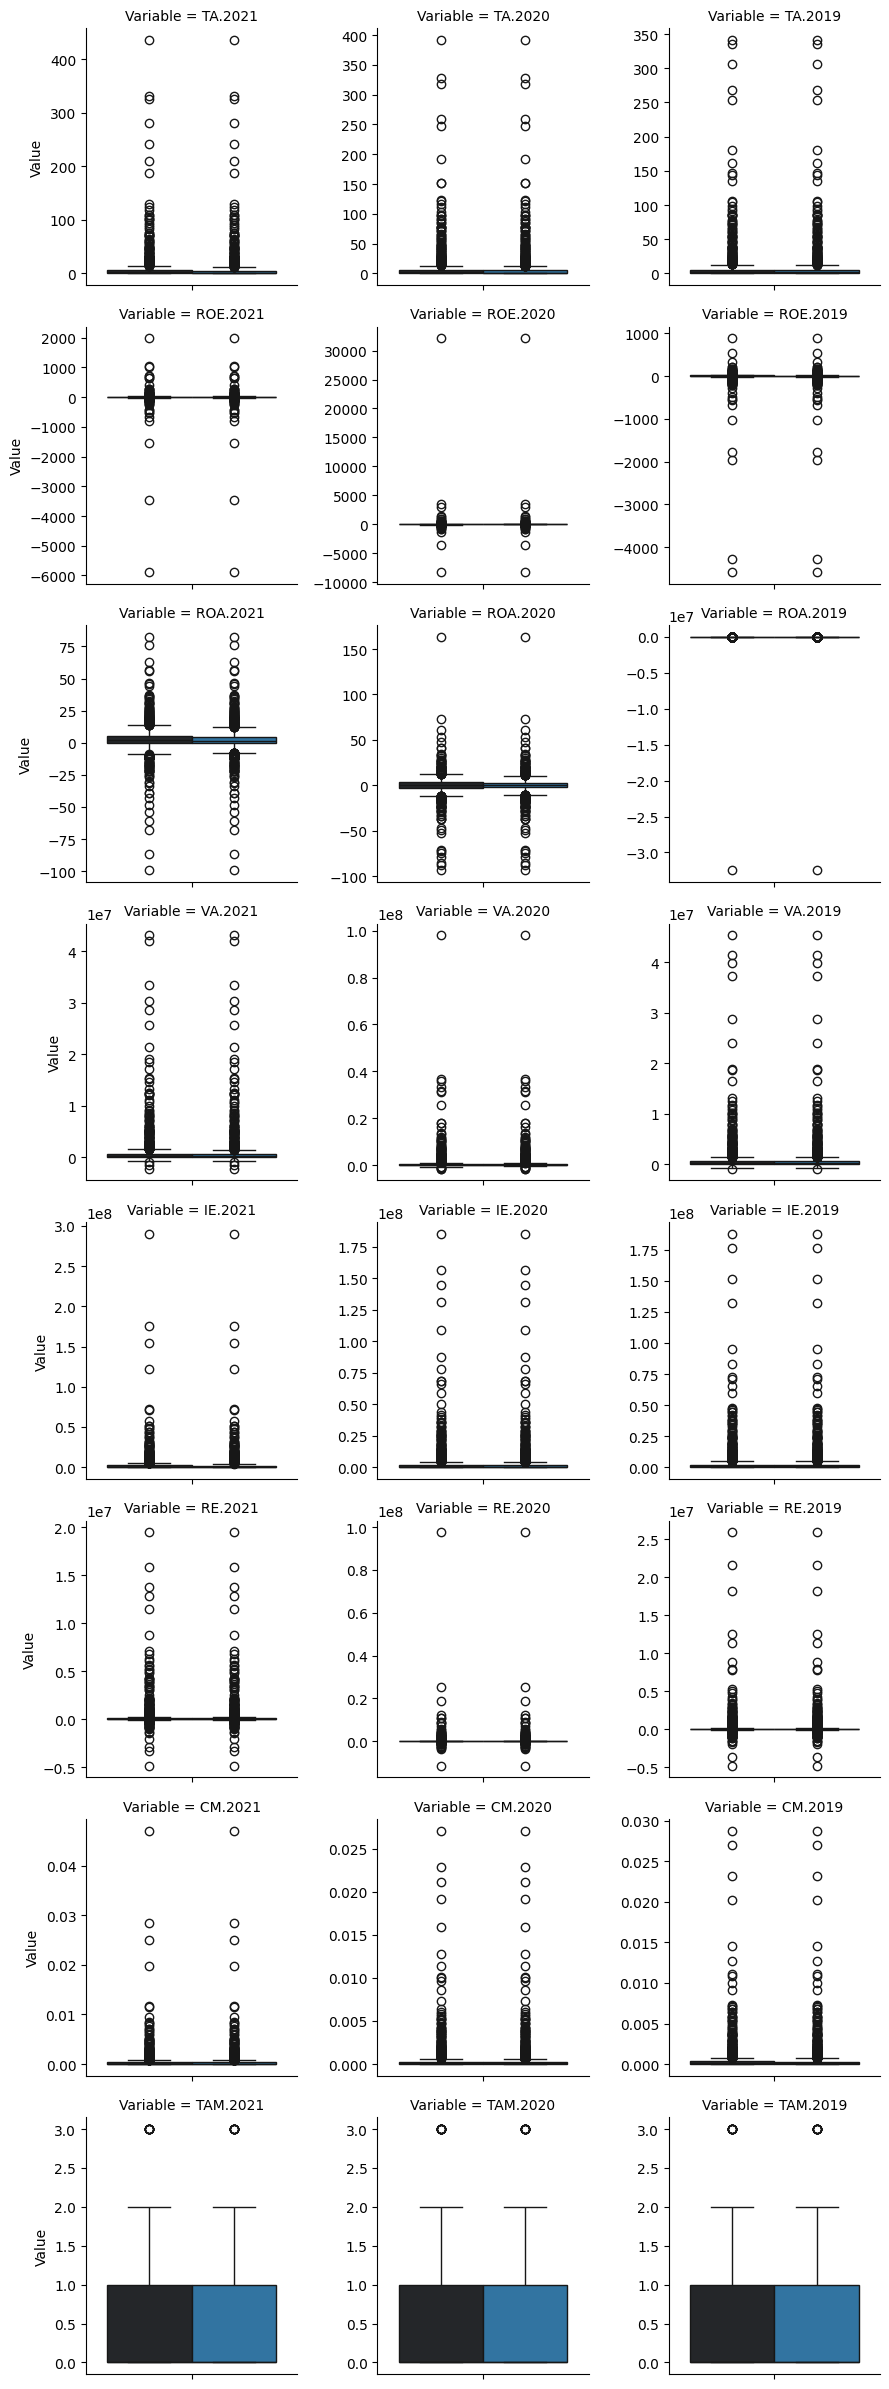

In [55]:
grid = sns.FacetGrid(combined_data, col='Variable', 
                    col_wrap=3, sharey=False)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore UserWarnings from seaborn

grid.map_dataframe(sns.boxplot, y='Value', hue='Condition', 
                   native_scale=True)
plt.show()

In [56]:
df_imputed_final[categorical_economical] = df_imputed_final[categorical_economical].astype(int)

Puesto que no hay diferencias significativas entre las distribuciones de datos antes y despues de imputacion, sigamos con el analisis.

## Análisis de datos anómalos


Una vez terminada la imputación de NA’s a nuestras variables económicas, procedemos a realizar el análisis de datos anómalos con el objetivo de observar si existen o no, y en caso de su existencia si se deberán eliminar.

Para ello, definiremos dos funciones auxiliares: una para calcular desviacion absoluta mediana (MAD) y otra para calcular la distancia de cada dato al valor de MAD de la variable en terminos relativos al valor de MAD.

Asumimos que los datos anomalos son aquellos que estan 3 o mas veces mas lejos que MAD.

In [57]:
def mad(s):
    return np.median(np.abs(s - np.median(s)))

def distance(s):
    return np.abs((s - np.median(s)) / mad(s))

In [58]:
df_imputed_mad = df_imputed.apply(mad, axis=0)

threshold = 3

anomalous_count = (df_imputed.apply(distance) > threshold).sum()
anomalous_percentage = anomalous_count / df_imputed.shape[0]

anomalous_table = pd.concat([pd.Series(df_imputed_mad.round(2), name='MAD'),
           pd.Series(anomalous_count, name='Count'), 
           pd.Series(anomalous_percentage, name='Percentage')], axis=1).sort_values(by='Percentage', ascending=False)

anomalous_table.loc[~anomalous_table.index.str.contains('TAM'), :]

,MAD,Count,Percentage
RE.2021,34141.86,457,0.312372
RE.2019,27290.00,439,0.300068
RE.2020,35650.97,432,0.295284
IE.2020,401022.43,377,0.257690
CM.2020,0.00,377,0.257690
VA.2020,128231.74,368,0.251538
TA.2021,1.27,368,0.251538
CM.2021,0.00,364,0.248804
IE.2021,469937.43,364,0.248804
TA.2020,1.28,363,0.248120


El numero de datos anomalos varia entre 18 y 31 entre las variables numericas economicas que es relativamente grande para eliminar estos valores.

El numero elevado de outliers nos puede perjudicar el analisis posterior. Por tanto, merecia la pena transformar estas variables con una funcion. 

Primero intentaremos transformar estas variables logaritmicamente y miremos las distribuciones despues de transformacion.

# Exploracion de la BBDD

In [59]:
locations = pd.read_csv('locations.csv')

## Analisis de datos exploratorio

### Ubicacion de las bodegas

Dado una cantidad grande de bodegas, seria interesante ver tanto sus ubicaciones como el hecho de ser o no el punto de enoturismo. 

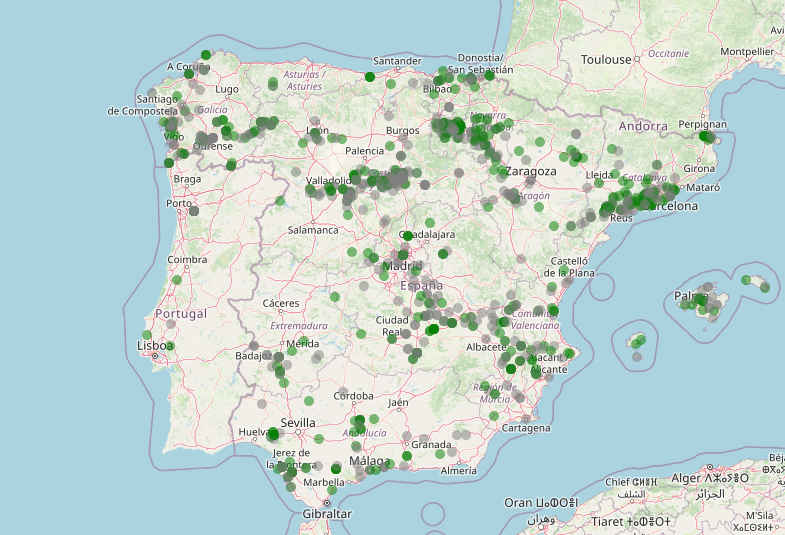

In [58]:
import folium

# Replace with your actual data
city_names = locations['Localidad']
latitude = locations['latitude']
longitude = locations['longitude']

# Define Spain's bounding box coordinates (replace with more precise values if needed)
southwest_lat = 36
southwest_lon = -9
northeast_lat = 44
northeast_lon = 3

# Define a colormap with two colors
colorscale = ['grey', 'green']

# Define map starting location (e.g., center of Spain)
map = folium.Map(location=[40.4, -3.7], zoom_start=6, bounds=[[southwest_lat, southwest_lon], [northeast_lat, northeast_lon]])

# Add markers with tooltips
for i in range(len(city_names)):
  city_name = city_names[i]
  lat = latitude[i]
  lon = longitude[i]
  folium.CircleMarker([lat, lon], tooltip=city_name, fill_color=colorscale[int(df_imputed_final['enotourism'][i])],
                      radius=5, fill_opacity=0.5, weight=0).add_to(map)


from IPython.display import Image

# Specify the path to the PNG image file
image_path = 'bodegas_map.png'

# Display the PNG image
Image(filename=image_path)

En el mapa se ven clusteres de bodegas en varias provincias de España. Es evidente también que dentro de estos clusteres hay tanto bodegas que son puntos para enoturistas y las que no.

Un problema a resolver sería identificar palabras clave que utilizan las bodegas puntos de enoturismo en sus paginas web para luego promocionar el resto de bodegas.

### Correlacion entre indicadores financieros por año

#### 2019

In [60]:
df_imputed_final.loc[:, df_imputed_final.columns.str.contains('2019')].corr()

,TA.2019,TAM.2019,ROE.2019,ROA.2019,VA.2019,IE.2019,RE.2019,CM.2019
TA.2019,1.000000,0.587658,0.014596,0.007843,0.882542,0.828631,0.591290,0.828631
TAM.2019,0.587658,1.000000,0.031849,0.016388,0.576264,0.605891,0.348976,0.605891
ROE.2019,0.014596,0.031849,1.000000,-0.009022,0.015562,0.014893,0.011395,0.014893
ROA.2019,0.007843,0.016388,-0.009022,1.000000,0.014219,0.007269,0.019004,0.007269
VA.2019,0.882542,0.576264,0.015562,0.014219,1.000000,0.840408,0.758795,0.840408
IE.2019,0.828631,0.605891,0.014893,0.007269,0.840408,1.000000,0.427039,1.000000
RE.2019,0.591290,0.348976,0.011395,0.019004,0.758795,0.427039,1.000000,0.427039
CM.2019,0.828631,0.605891,0.014893,0.007269,0.840408,1.000000,0.427039,1.000000


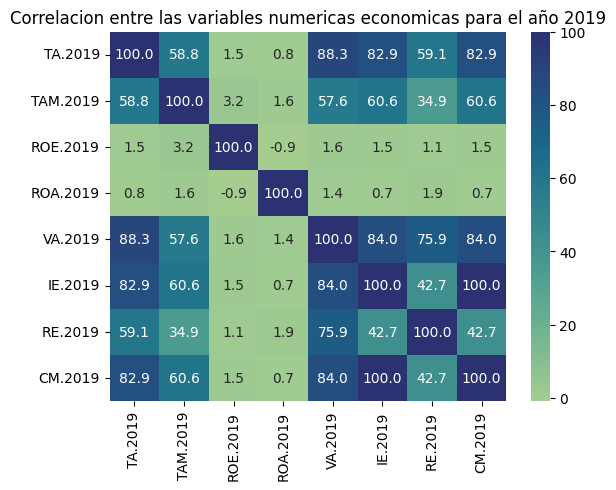

In [61]:
sns.heatmap(df_imputed_final.loc[:, df_imputed_final.columns.str.contains('2019')].corr()*100,
            annot=True, fmt=".1f",
            cmap="crest")
plt.title("Correlacion entre las variables numericas economicas para el año 2019")
plt.show()

#### 2020

In [62]:
df_imputed_final.loc[:, df_imputed_final.columns.str.contains('2020')].corr()

,TA.2020,TAM.2020,ROE.2020,ROA.2020,VA.2020,IE.2020,RE.2020,CM.2020
TA.2020,1.000000,0.598949,-0.007107,0.078536,0.876709,0.860009,0.533607,0.860009
TAM.2020,0.598949,1.000000,-0.025382,0.103084,0.494242,0.617848,0.210227,0.617848
ROE.2020,-0.007107,-0.025382,1.000000,0.054289,-0.002640,-0.005555,0.002803,-0.005555
ROA.2020,0.078536,0.103084,0.054289,1.000000,0.138023,0.082471,0.134376,0.082471
VA.2020,0.876709,0.494242,-0.002640,0.138023,1.000000,0.743246,0.824709,0.743246
IE.2020,0.860009,0.617848,-0.005555,0.082471,0.743246,1.000000,0.337190,1.000000
RE.2020,0.533607,0.210227,0.002803,0.134376,0.824709,0.337190,1.000000,0.337190
CM.2020,0.860009,0.617848,-0.005555,0.082471,0.743246,1.000000,0.337190,1.000000


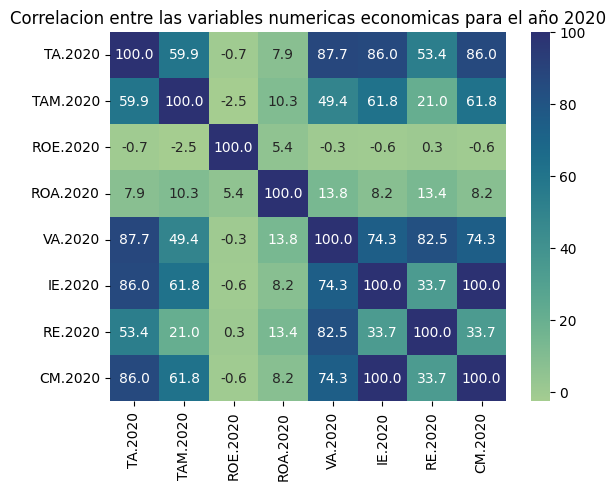

In [63]:
sns.heatmap(df_imputed_final.loc[:, df_imputed_final.columns.str.contains('2020')].corr()*100,
            annot=True, fmt=".1f",
            cmap="crest")
plt.title("Correlacion entre las variables numericas economicas para el año 2020")
plt.show()

#### 2021

In [64]:
df_imputed_final.loc[:, df_imputed_final.columns.str.contains('2021')].corr()

,TA.2021,TAM.2021,ROE.2021,ROA.2021,VA.2021,IE.2021,RE.2021,CM.2021
TA.2021,1.000000,0.521281,0.001107,0.039239,0.846203,0.762665,0.653295,0.762665
TAM.2021,0.521281,1.000000,0.007434,0.123892,0.603446,0.548095,0.418589,0.548095
ROE.2021,0.001107,0.007434,1.000000,-0.028177,0.008880,0.003317,0.021044,0.003317
ROA.2021,0.039239,0.123892,-0.028177,1.000000,0.131238,0.062957,0.205932,0.062957
VA.2021,0.846203,0.603446,0.008880,0.131238,1.000000,0.859514,0.806977,0.859514
IE.2021,0.762665,0.548095,0.003317,0.062957,0.859514,1.000000,0.529568,1.000000
RE.2021,0.653295,0.418589,0.021044,0.205932,0.806977,0.529568,1.000000,0.529568
CM.2021,0.762665,0.548095,0.003317,0.062957,0.859514,1.000000,0.529568,1.000000


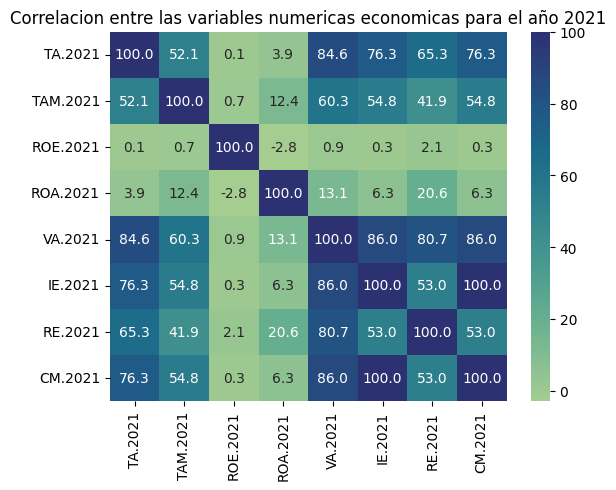

In [65]:
sns.heatmap(df_imputed_final.loc[:, df_imputed_final.columns.str.contains('2021')].corr()*100,
            annot=True, fmt=".1f",
            cmap="crest")
plt.title("Correlacion entre las variables numericas economicas para el año 2021")
plt.show()

### Palabras con el mayor recuento medio

In [66]:
columns_words = numerical_webscraping[numerical_webscraping.str.contains('keyword')]
columns_roots = numerical_webscraping[numerical_webscraping.str.contains('stems')]

webscraping_wordcount_mean = df[list(columns_words) + ['enotourism']].mean()

In [67]:
webscraping_wordcount_mean.sort_values(ascending=False).head(20)

keywords_reserva                   151.075871
keywords_vinedos                    97.261791
keywords_experiencia                67.228298
keywords_enoturismo                 63.601504
keywords_do                         61.000000
keywords_historia                   58.278195
keywords_personal                   38.093643
keywords_cata                       36.298701
keywords_casa                       35.088175
keywords_visita                     34.897471
keywords_calidad                    33.812030
keywords_categoria                  26.104580
keywords_lujo                       25.746411
keywords_maridaje                   20.209159
keywords_region                     13.928230
keywords_cultura                    13.908407
keywords_internacional              11.970608
keywords_actividades                11.745728
keywords_hotel                      11.354067
keywords_denominacion_de_origen     11.187970
dtype: float64

In [68]:
worduse_by_enotourism = df[list(columns_words) + ['enotourism']].groupby('enotourism').mean().reset_index().melt(id_vars=['enotourism'])
#worduse_by_enotourism.columns = worduse_by_enotourism.columns.str.rsplit('_', n=1)

In [69]:
worduse_by_enotourism['variable'] = worduse_by_enotourism['variable'].str.removeprefix('keywords_')

In [70]:
worduse_by_enotourism.sort_values(by=['value', 'variable'], ascending=False, inplace=True)
worduse_by_enotourism = worduse_by_enotourism.head(50)

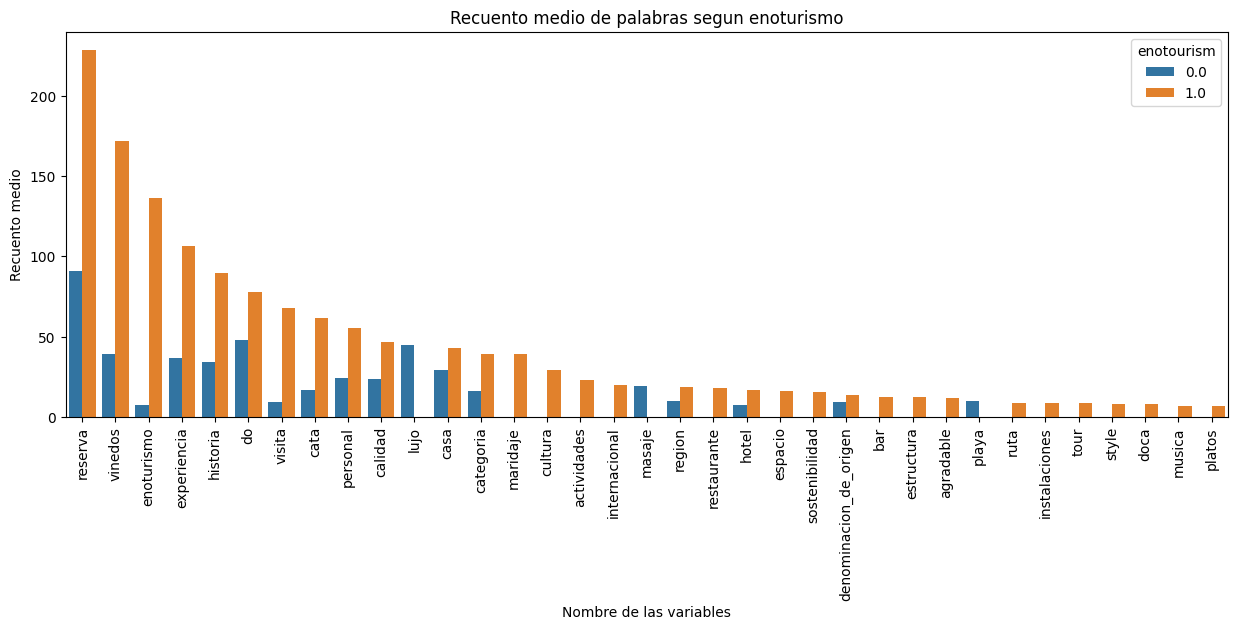

In [71]:
plt.figure(figsize=(15,5))
sns.barplot(worduse_by_enotourism, x='variable', y='value', hue='enotourism')

plt.title("Recuento medio de palabras segun enoturismo")
plt.xlabel("Nombre de las variables")
plt.xticks(rotation=90)
plt.ylabel("Recuento medio")
plt.show()

## Aprendizaje no supervisado

Esta parte del trabajo usara solo las variables numericas de la base original. 
Primero a las variables mencionadas se va a aplicar la tecnica de **componentes principales (PCA)** y luego **analisis de clustering**.

### Análisis de los componentes principales (PCA)

Antes de aplicar PCA a los datos escalemos sus valores dado que tienen rangos diferentes lo que puede perjudicar a los resultados obtenidos a partir del analisis.

#### Centrar y escalar las variables

Tenemos un conjunto de variables economicas para 3 años. Escalemos todo el conjunto para luego analizar los datos de varios años por separado.


In [72]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(df_imputed_final.loc[:, numerical_economical])

df_imputed_scaled = pd.DataFrame(transformer.transform(df_imputed_final.loc[:, numerical_economical]), columns=numerical_economical, index=df_imputed_final.index)

<Axes: >

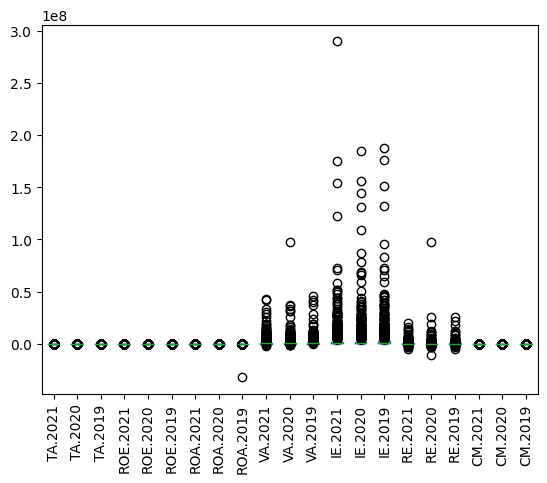

In [73]:
df_imputed_final.loc[:, numerical_economical].plot(kind='box', rot=90)

<Axes: >

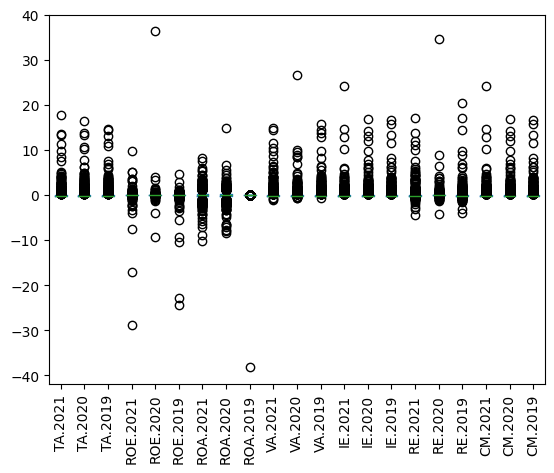

In [74]:
df_imputed_scaled.plot(kind='box', rot=90)

#### Seleccionar el número de componentes principales

Dado que vamos a analizar los conjuntos de datos por separado, creemos 3 conjuntos de datos, uno para cada año.

In [75]:
df_economy_2019 = df_imputed_scaled.loc[:, df_imputed_scaled[numerical_economical].columns.str.contains('2019')]
df_economy_2020 = df_imputed_scaled.loc[:, df_imputed_scaled[numerical_economical].columns.str.contains('2020')]
df_economy_2021 = df_imputed_scaled.loc[:, df_imputed_scaled[numerical_economical].columns.str.contains('2021')]

In [77]:
from sklearn.decomposition import PCA 

np.random.seed(0)

df_economy_2019_pca = PCA()
df_economy_2020_pca = PCA()
df_economy_2021_pca = PCA()

df_economy_2019_pca_data = df_economy_2019_pca.fit_transform(df_economy_2019)
df_economy_2020_pca_data = df_economy_2020_pca.fit_transform(df_economy_2020)
df_economy_2021_pca_data = df_economy_2021_pca.fit_transform(df_economy_2021)

# Calculate explained variance ratio
df_economy_2019_explained_variance = df_economy_2019_pca.explained_variance_ratio_
df_economy_2020_explained_variance = df_economy_2020_pca.explained_variance_ratio_
df_economy_2021_explained_variance = df_economy_2021_pca.explained_variance_ratio_

In [139]:
df_economy_2019_pca.explained_variance_

array([4.01749388e+00, 1.00999087e+00, 9.91471036e-01, 7.48311675e-01,
       1.79633987e-01, 5.78865152e-02, 1.11022299e-16])

In [136]:
df_economy_2019_pca.explained_variance_ratio_

array([5.73535402e-01, 1.44185788e-01, 1.41541905e-01, 1.06828598e-01,
       2.56444574e-02, 8.26384974e-03, 1.58494874e-17])

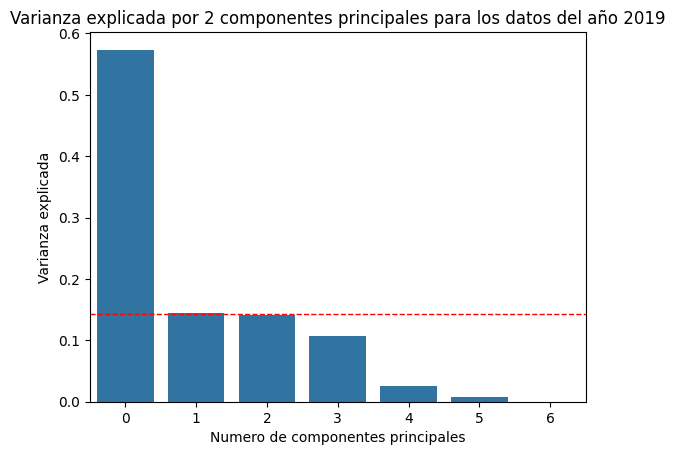

In [78]:
sns.barplot(df_economy_2019_explained_variance)
plt.axhline(y=df_economy_2019_explained_variance.mean(), color='r', linestyle='--', linewidth=1)
plt.title('Varianza explicada por 2 componentes principales para los datos del año 2019')
plt.xlabel("Numero de componentes principales")
plt.ylabel("Varianza explicada")
plt.show()

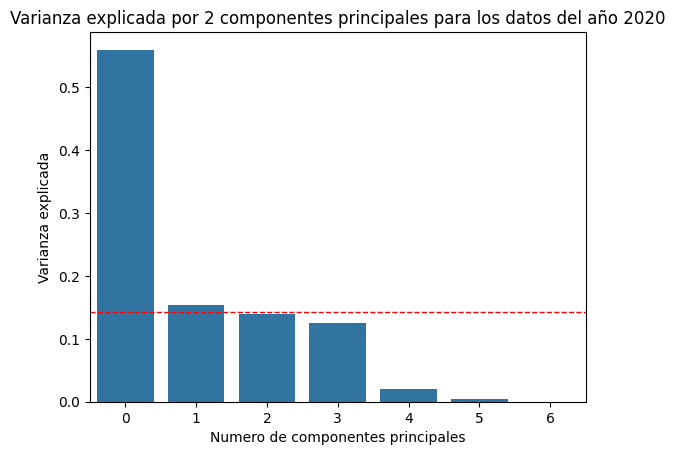

In [79]:
sns.barplot(df_economy_2020_explained_variance)
plt.axhline(y=df_economy_2020_explained_variance.mean(), color='r', linestyle='--', linewidth=1)
plt.title('Varianza explicada por 2 componentes principales para los datos del año 2020')
plt.xlabel("Numero de componentes principales")
plt.ylabel("Varianza explicada")
plt.show()

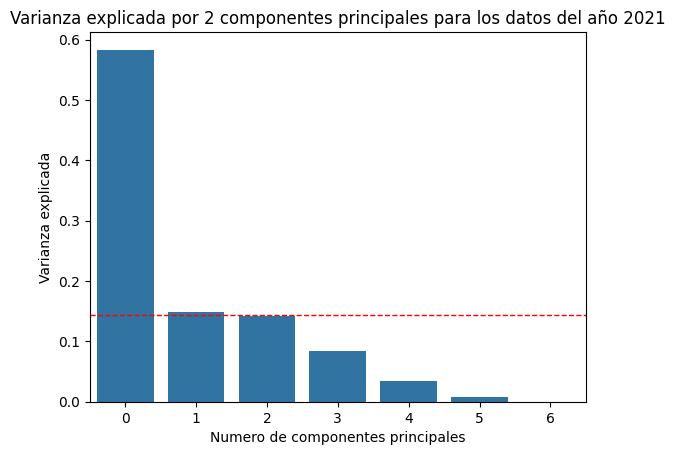

In [80]:
sns.barplot(df_economy_2021_explained_variance)
plt.axhline(y=df_economy_2021_explained_variance.mean(), color='r', linestyle='--', linewidth=1)
plt.title('Varianza explicada por 2 componentes principales para los datos del año 2021')
plt.xlabel("Numero de componentes principales")
plt.ylabel("Varianza explicada")
plt.show()

En los datos de dos de los tres años 2 componentes principales contienen más informacion de la media explicada por todos los componentes. Entonces, quedamos con 2 componentes principales para el analisis.

Hagamos unas graficas cara cada año para ver como se relacionan las variables con los componentes principales.

<Figure size 1000x1000 with 0 Axes>

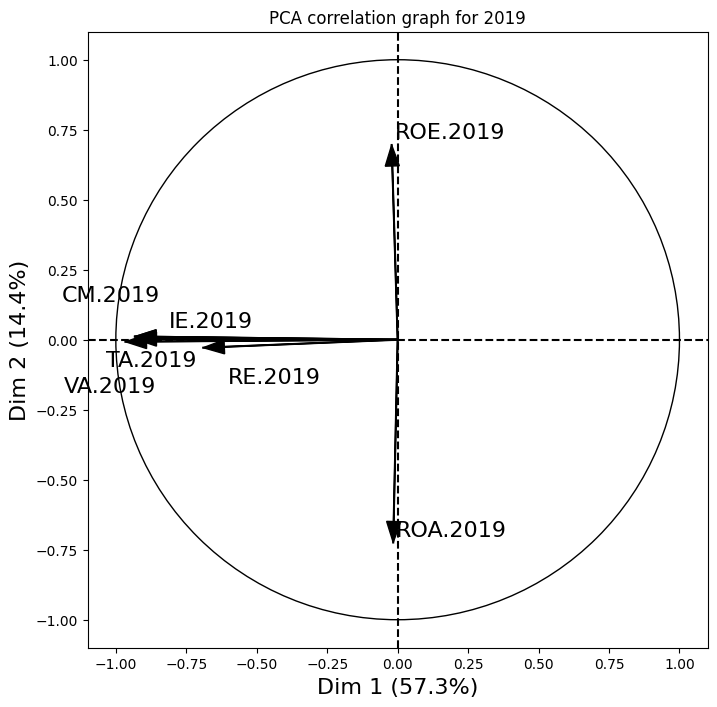

<Figure size 1000x1000 with 0 Axes>

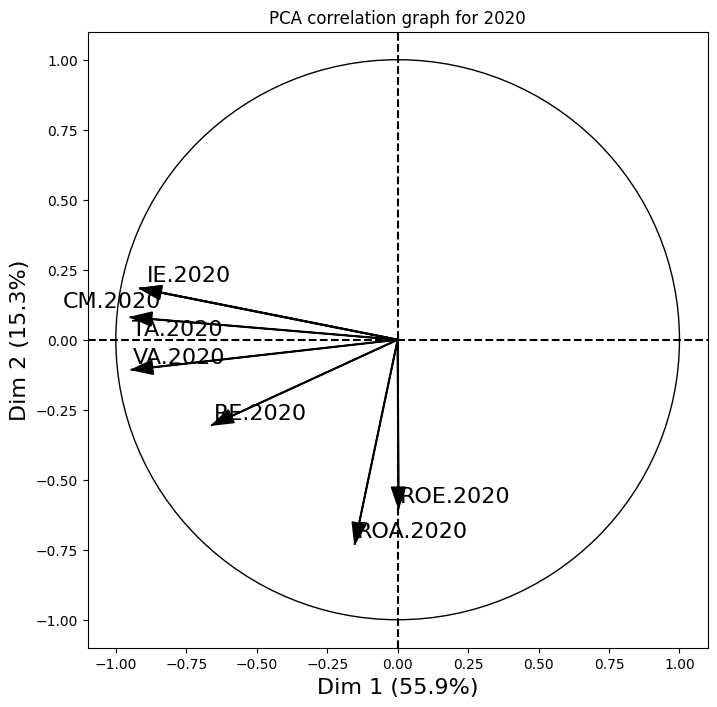

<Figure size 1000x1000 with 0 Axes>

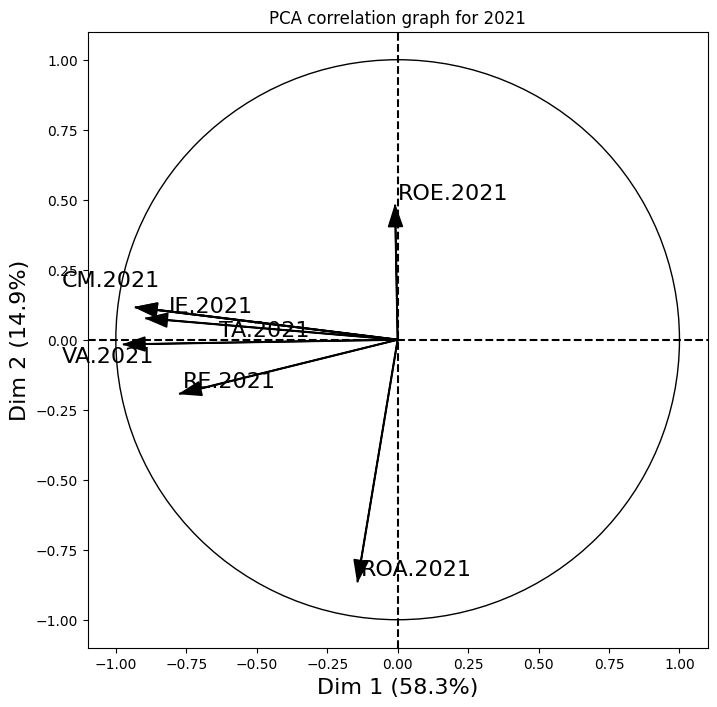

In [81]:
from mlxtend.plotting import plot_pca_correlation_graph
import matplotlib.pyplot as plt

years = ['2019', '2020', '2021']

for year in years:
    df_imputed_scaled_by_year = df_imputed_scaled.loc[:, df_imputed_scaled.columns.str.contains(year)]
    
    feature_names = list(df_imputed_scaled_by_year.columns)
    
    plt.figure(figsize=(10,10))
    figure, correlation_matrix = plot_pca_correlation_graph(df_imputed_scaled_by_year, 
                                                            feature_names,
                                                            dimensions=(1, 2),
                                                            figure_axis_size=8)

    plt.title(f"PCA correlation graph for {year}")
    plt.show()

Se ve que todas las variables excepto ROE y ROA se relacionan más a la componente 1 y las variables ROE y ROA a la componente 2.

Ademas es evidente, que en el año 2020

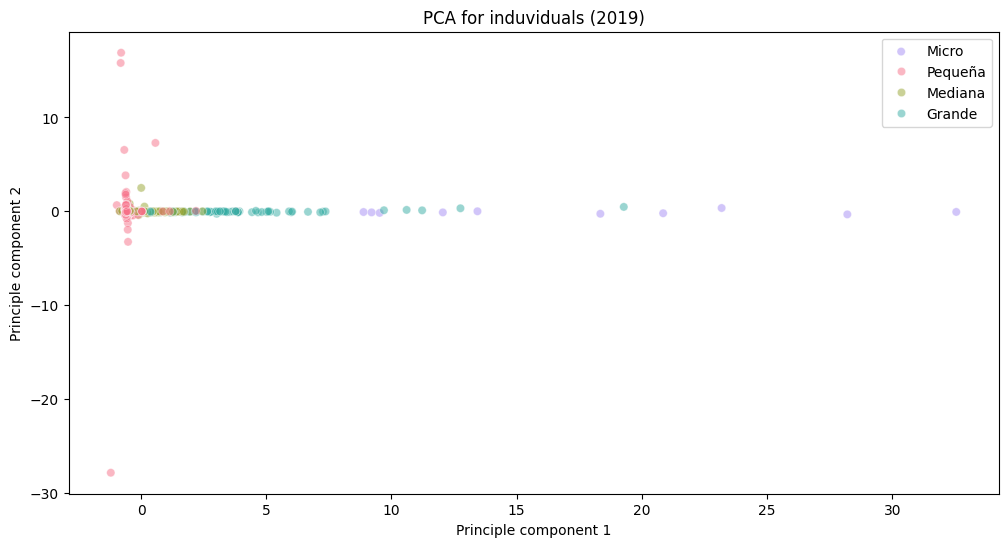

In [82]:
data_to_plot = pd.concat([pd.DataFrame(df_economy_2019_pca_data), df_imputed_final['TAM.2019'].reset_index(drop=True)], axis=1)

plt.figure(figsize=(12,6))
sns.set_palette(sns.color_palette("husl", 8))
sns.scatterplot(data_to_plot, x=0, y=1, hue='TAM.2019', alpha=0.5, palette=sns.color_palette("husl", 4))
plt.title("PCA for induviduals (2019)")
plt.xlabel("Principle component 1")
plt.ylabel("Principle component 2")
plt.legend(['Micro','Pequeña','Mediana','Grande'])
plt.show()

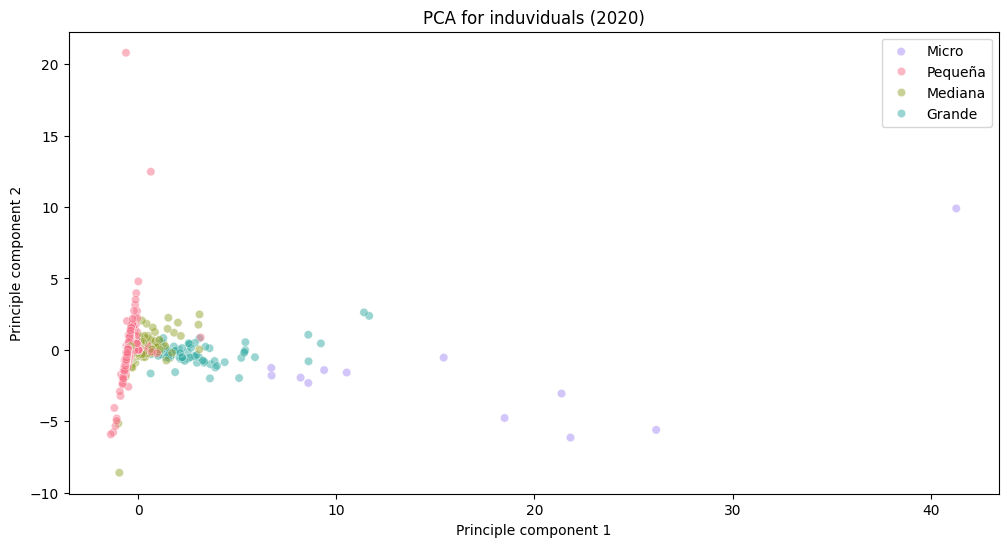

In [83]:
data_to_plot = pd.concat([pd.DataFrame(df_economy_2020_pca_data), df_imputed_final['TAM.2020'].reset_index(drop=True)], axis=1)

plt.figure(figsize=(12,6))
sns.set_palette(sns.color_palette("husl", 8))
sns.scatterplot(data_to_plot, x=0, y=1, hue='TAM.2020', alpha=0.5, palette=sns.color_palette("husl", 4))
plt.title("PCA for induviduals (2020)")
plt.xlabel("Principle component 1")
plt.ylabel("Principle component 2")
plt.legend(['Micro','Pequeña','Mediana','Grande'])
plt.show()

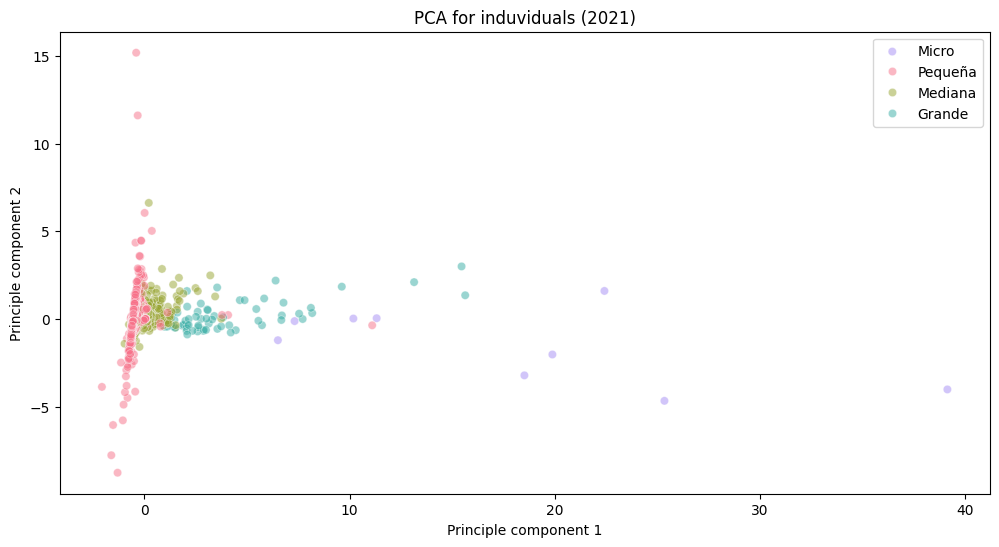

In [84]:
data_to_plot = pd.concat([pd.DataFrame(df_economy_2021_pca_data), df_imputed_final['TAM.2021'].reset_index(drop=True)], axis=1)

plt.figure(figsize=(12,6))
sns.scatterplot(data_to_plot, x=0, y=1, hue='TAM.2021', alpha=0.5, palette=sns.color_palette("husl", 4))
plt.title("PCA for induviduals (2021)")
plt.xlabel("Principle component 1")
plt.ylabel("Principle component 2")
plt.legend(['Micro','Pequeña','Mediana','Grande'])
plt.show()

### Clustering analisis

En primer lugar calculamos la distancia euclídea en nuestros datos:

In [85]:
from sklearn.metrics import pairwise_distances

# Calculate pairwise distances using Euclidean distance (default)
distances = pairwise_distances(df_economy_2019_pca_data)

Asi pues hemos utilizado la medida de distancia euclídea para agrupar las empresas en función de su similitud o diferencia en un espacio multidimensional de las variables económicas de la base de datos. Este enfoque nos ha permitido identificar grupos de empresas que comparten características similares en términos de rentabilidad, competividad y eficiencia.

Posteriormente, procederemos a calcular el estadístico de Hopkins. Este análisis detallado nos permite obtener una perspectiva integral sobre la tendencia de agrupación en los datos estandarizados.

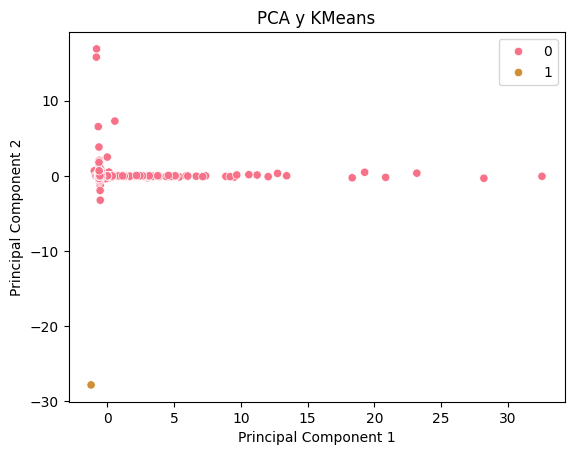

In [86]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=2, random_state=23)
labels = kmeans.fit_predict(df_economy_2019_pca_data)

#plt.scatter(df_economy_2019_pca_data[:, 0], df_economy_2019_pca_data[:, 1], c=kmeans.labels_, cmap='viridis')
sns.scatterplot(pd.DataFrame(df_economy_2019_pca_data), x=0, y=1, hue=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA y KMeans')
#plt.legend()
plt.show()

In [87]:
pd.Series(labels).value_counts()

0    1462
1       1
Name: count, dtype: int64

## Aprendizaje supervisado

Para el aprendizaje supervisado utilicemos solo las variables de webscraping como variables independientes y la variable enotourism como variable de etiquetas.
Ademas, separemos el conjunto de variables de webscraping en las variables de las palabras completas (**webscraping_words**) y de variables de las raices de palabras (**webscraping_roots**).

In [88]:
webscraping_words_columns = [*list(df_imputed_final.columns[df_imputed_final.columns.str.contains('keyword')]), 'enotourism']
webscraping_words = df_imputed_final.loc[:, webscraping_words_columns]
webscraping_words.shape

(1463, 103)

In [89]:
webscraping_roots_columns = [*list(df_imputed_final.columns[df_imputed_final.columns.str.contains('stems')]), 'enotourism']
webscraping_roots = df_imputed_final.loc[:, webscraping_roots_columns]
webscraping_roots.shape

(1463, 102)

### Entrenamos los modelos para el conjunto de palabras completas

**Empecemos entrenar modelos con el conjunto de las palabras completas** y luego comparemos los resultados con el subconjunto de las raices.

#### Dividimos en train y test

In [91]:
from sklearn.model_selection import train_test_split

X = webscraping_words.drop(columns=['enotourism']).astype(int)
y = webscraping_words['enotourism'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Escalemos las variables

In [92]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.fit_transform(X_test.values)

#### Arboles de decision

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report


tree_words = DecisionTreeClassifier(random_state=42)

tree_words.fit(X_train_scaled, y_train)

y_train_predictions = tree_words.predict(X_train_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_train, y_train_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_train, y_train_predictions))

Accuracy: 0.9965811965811966
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       651
           1       1.00      0.99      1.00       519

    accuracy                           1.00      1170
   macro avg       1.00      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170



In [94]:
test_contingency = pd.crosstab(y_train, y_train_predictions, rownames=['True Label'], colnames=['Predicted Label'])
test_contingency

Predicted Label,0,1
True Label,,
0,651,0
1,4,515


#### Bosque aleatorio

In [95]:
from sklearn.ensemble import RandomForestClassifier

random_forest_words = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)

random_forest_words.fit(X_train_scaled, y_train)

y_train_predictions = random_forest_words.predict(X_train_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_train, y_train_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_train, y_train_predictions))

Accuracy: 0.8632478632478633
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       651
           1       0.87      0.82      0.84       519

    accuracy                           0.86      1170
   macro avg       0.86      0.86      0.86      1170
weighted avg       0.86      0.86      0.86      1170



In [96]:
test_contingency = pd.crosstab(y_train, y_train_predictions, rownames=['True Label'], colnames=['Predicted Label'], normalize=True)
test_contingency

Predicted Label,0,1
True Label,,
0,0.501709,0.054701
1,0.082051,0.361538


#### Vecino mas proximo

In [97]:
from sklearn.neighbors import KNeighborsClassifier

nearest_neighbour_words = KNeighborsClassifier(n_neighbors=5)

nearest_neighbour_words.fit(X_train_scaled, y_train)

y_train_predictions = nearest_neighbour_words.predict(X_train_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_train, y_train_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_train, y_train_predictions))

Accuracy: 0.7974358974358975
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       651
           1       0.81      0.71      0.76       519

    accuracy                           0.80      1170
   macro avg       0.80      0.79      0.79      1170
weighted avg       0.80      0.80      0.80      1170



In [98]:
test_contingency = pd.crosstab(y_train, y_train_predictions, rownames=['True Label'], colnames=['Predicted Label'])
test_contingency

Predicted Label,0,1
True Label,,
0,565,86
1,151,368


#### Naive Bayes

In [99]:
from sklearn.naive_bayes import GaussianNB

naive_bayes_words = GaussianNB()

naive_bayes_words.fit(X_train_scaled, y_train)

y_train_predictions = naive_bayes_words.predict(X_train_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_train, y_train_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_train, y_train_predictions))

Accuracy: 0.6726495726495727
              precision    recall  f1-score   support

           0       0.64      0.94      0.76       651
           1       0.82      0.34      0.48       519

    accuracy                           0.67      1170
   macro avg       0.73      0.64      0.62      1170
weighted avg       0.72      0.67      0.64      1170



In [100]:
test_contingency = pd.crosstab(y_train, y_train_predictions, rownames=['True Label'], colnames=['Predicted Label'])
test_contingency

Predicted Label,0,1
True Label,,
0,612,39
1,344,175


#### Maquinas de soporte vectorial

In [101]:
from sklearn.svm import SVC

svm_words = SVC(kernel='linear', random_state=42)

svm_words.fit(X_train_scaled, y_train)

y_train_predictions = svm_words.predict(X_train_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_train, y_train_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_train, y_train_predictions))

Accuracy: 0.6974358974358974
              precision    recall  f1-score   support

           0       0.66      0.94      0.78       651
           1       0.85      0.39      0.53       519

    accuracy                           0.70      1170
   macro avg       0.75      0.67      0.65      1170
weighted avg       0.74      0.70      0.67      1170



In [102]:
test_contingency = pd.crosstab(y_train, y_train_predictions, rownames=['True Label'], colnames=['Predicted Label'])
test_contingency

Predicted Label,0,1
True Label,,
0,614,37
1,317,202


In [103]:
test_contingency = pd.crosstab(y_train, y_train_predictions, 
                               rownames=['True Label'], colnames=['Predicted Label'],
                               normalize=True)
test_contingency

Predicted Label,0,1
True Label,,
0,0.524786,0.031624
1,0.270940,0.172650


#### Validacion cruzada

In [104]:
from sklearn.model_selection import cross_val_score

tree_words_auc = cross_val_score(tree_words, X_train_scaled, y_train,
                             scoring='roc_auc', cv=10)
random_forest_words_auc = cross_val_score(random_forest_words, X_train_scaled, y_train,
                             scoring='roc_auc', cv=10)
nearest_neighbour_words_auc = cross_val_score(nearest_neighbour_words, X_train_scaled, y_train,
                             scoring='roc_auc', cv=10)
naive_bayes_words_auc = cross_val_score(naive_bayes_words, X_train_scaled, y_train,
                             scoring='roc_auc', cv=10)
svm_words_auc = cross_val_score(svm_words, X_train_scaled, y_train,
                             scoring='roc_auc', cv=10)



In [105]:
cross_val_scores_words = pd.concat([pd.Series(tree_words_auc).describe(), 
           pd.Series(random_forest_words_auc).describe(), 
           pd.Series(nearest_neighbour_words_auc).describe(), 
           pd.Series(naive_bayes_words_auc).describe(), 
           pd.Series(svm_words_auc).describe()], axis=1)

cross_val_scores_words.columns = ['01 Decision Tree',
                            '02 Random Forest',
                            '03 Nearest Neighbour',
                            '04 Naive Bayes',
                            '05 Support Vector Machine']

cross_val_scores_words

,01 Decision Tree,02 Random Forest,03 Nearest Neighbour,04 Naive Bayes,05 Support Vector Machine
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.743782,0.893371,0.774625,0.759334,0.823651
std,0.034564,0.030316,0.050337,0.043688,0.041241
min,0.685207,0.857396,0.705473,0.714053,0.779586
25%,0.732396,0.866827,0.752478,0.730658,0.794822
50%,0.738018,0.893639,0.760503,0.749332,0.804956
75%,0.764090,0.913388,0.812821,0.758728,0.846055
max,0.807544,0.947337,0.858580,0.854734,0.907988


### Entrenamos los modelos para el conjunto de raices de palabras

#### Dividimos en train y test

In [106]:
from sklearn.model_selection import train_test_split

X = webscraping_roots.drop(columns=['enotourism']).astype(int)
y = webscraping_roots['enotourism'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Escalemos las variables

In [107]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.fit_transform(X_test.values)

#### Arboles de decision

In [108]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report


tree_roots = DecisionTreeClassifier(random_state=42)

tree_roots.fit(X_train_scaled, y_train)

y_train_predictions = tree_roots.predict(X_train_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_train, y_train_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_train, y_train_predictions))

Accuracy: 0.9991452991452991
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       651
           1       1.00      1.00      1.00       519

    accuracy                           1.00      1170
   macro avg       1.00      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170



In [109]:
test_contingency = pd.crosstab(y_train, y_train_predictions, rownames=['True Label'], colnames=['Predicted Label'])
test_contingency

Predicted Label,0,1
True Label,,
0,651,0
1,1,518


#### Bosque aleatorio

In [110]:
from sklearn.ensemble import RandomForestClassifier

random_forest_roots = RandomForestClassifier(n_estimators=500, random_state=42)

random_forest_roots.fit(X_train_scaled, y_train)

y_train_predictions = random_forest_roots.predict(X_train_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_train, y_train_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_train, y_train_predictions))

Accuracy: 0.9991452991452991
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       651
           1       1.00      1.00      1.00       519

    accuracy                           1.00      1170
   macro avg       1.00      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170



In [111]:
test_contingency = pd.crosstab(y_train, y_train_predictions, rownames=['True Label'], colnames=['Predicted Label'])
test_contingency

Predicted Label,0,1
True Label,,
0,651,0
1,1,518


#### Vecino mas proximo

In [112]:
from sklearn.neighbors import KNeighborsClassifier

nearest_neighbour_roots = KNeighborsClassifier(n_neighbors=5)

nearest_neighbour_roots.fit(X_train_scaled, y_train)

y_train_predictions = nearest_neighbour_roots.predict(X_train_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_train, y_train_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_train, y_train_predictions))

Accuracy: 0.8102564102564103
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       651
           1       0.82      0.74      0.78       519

    accuracy                           0.81      1170
   macro avg       0.81      0.80      0.81      1170
weighted avg       0.81      0.81      0.81      1170



In [114]:
test_contingency = pd.crosstab(y_train, y_train_predictions, rownames=['True Label'], colnames=['Predicted Label'])
test_contingency

Predicted Label,0,1
True Label,,
0,564,87
1,135,384


#### Naive Bayes

In [115]:
from sklearn.naive_bayes import GaussianNB

naive_bayes_roots = GaussianNB()

naive_bayes_roots.fit(X_train_scaled, y_train)

y_train_predictions = naive_bayes_roots.predict(X_train_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_train, y_train_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_train, y_train_predictions))

Accuracy: 0.6829059829059829
              precision    recall  f1-score   support

           0       0.65      0.94      0.77       651
           1       0.84      0.35      0.50       519

    accuracy                           0.68      1170
   macro avg       0.74      0.65      0.63      1170
weighted avg       0.73      0.68      0.65      1170



In [116]:
test_contingency = pd.crosstab(y_train, y_train_predictions, rownames=['True Label'], colnames=['Predicted Label'])
test_contingency

Predicted Label,0,1
True Label,,
0,615,36
1,335,184


#### Maquinas de soporte vectorial

In [117]:
from sklearn.svm import SVC

svm_roots = SVC(kernel='linear', random_state=42)

svm_roots.fit(X_train_scaled, y_train)

y_train_predictions = svm_roots.predict(X_train_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_train, y_train_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_train, y_train_predictions))

Accuracy: 0.7205128205128205
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       651
           1       0.87      0.44      0.58       519

    accuracy                           0.72      1170
   macro avg       0.77      0.69      0.69      1170
weighted avg       0.76      0.72      0.70      1170



In [118]:
test_contingency = pd.crosstab(y_train, y_train_predictions, rownames=['True Label'], colnames=['Predicted Label'])
test_contingency

Predicted Label,0,1
True Label,,
0,617,34
1,293,226


#### Validacion cruzada

In [119]:
from sklearn.model_selection import cross_val_score

tree_roots_auc = cross_val_score(tree_roots, X_train_scaled, y_train,
                             scoring='roc_auc', cv=10)
random_forest_roots_auc = cross_val_score(random_forest_roots, X_train_scaled, y_train,
                             scoring='roc_auc', cv=10)
nearest_neighbour_roots_auc = cross_val_score(nearest_neighbour_roots, X_train_scaled, y_train,
                             scoring='roc_auc', cv=10)
naive_bayes_roots_auc = cross_val_score(naive_bayes_roots, X_train_scaled, y_train,
                             scoring='roc_auc', cv=10)
svm_roots_auc = cross_val_score(svm_roots, X_train_scaled, y_train,
                             scoring='roc_auc', cv=10)



In [120]:
cross_val_scores_roots = pd.concat([pd.Series(tree_roots_auc).describe(), 
           pd.Series(random_forest_roots_auc).describe(), 
           pd.Series(nearest_neighbour_roots_auc).describe(), 
           pd.Series(naive_bayes_roots_auc).describe(), 
           pd.Series(svm_roots_auc).describe()], axis=1)

cross_val_scores_roots.columns = ['01 Decision Tree',
                            '02 Random Forest',
                            '03 Nearest Neighbour',
                            '04 Naive Bayes',
                            '05 Support Vector Machine']

cross_val_scores_roots

,01 Decision Tree,02 Random Forest,03 Nearest Neighbour,04 Naive Bayes,05 Support Vector Machine
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.749560,0.909614,0.788739,0.772877,0.834674
std,0.037771,0.027411,0.033769,0.042944,0.042167
min,0.701923,0.866864,0.729734,0.727219,0.786982
25%,0.719231,0.900074,0.772781,0.738462,0.798521
50%,0.741864,0.907618,0.786021,0.764793,0.829734
75%,0.770018,0.923410,0.809960,0.787204,0.859687
max,0.808876,0.964497,0.839645,0.847633,0.916864


### Comparacion de resultados de validacion cruzada para los conjuntos de palabras completas y las raices de palabras

Despues de obtener los resultados de validacion cruzada para ambos subconjuntos de datos en formato numerico, comparemoslas graficamente con el fin de elegir un subconjunto que demuestre mejores resultados de prediccion con los datos de train.

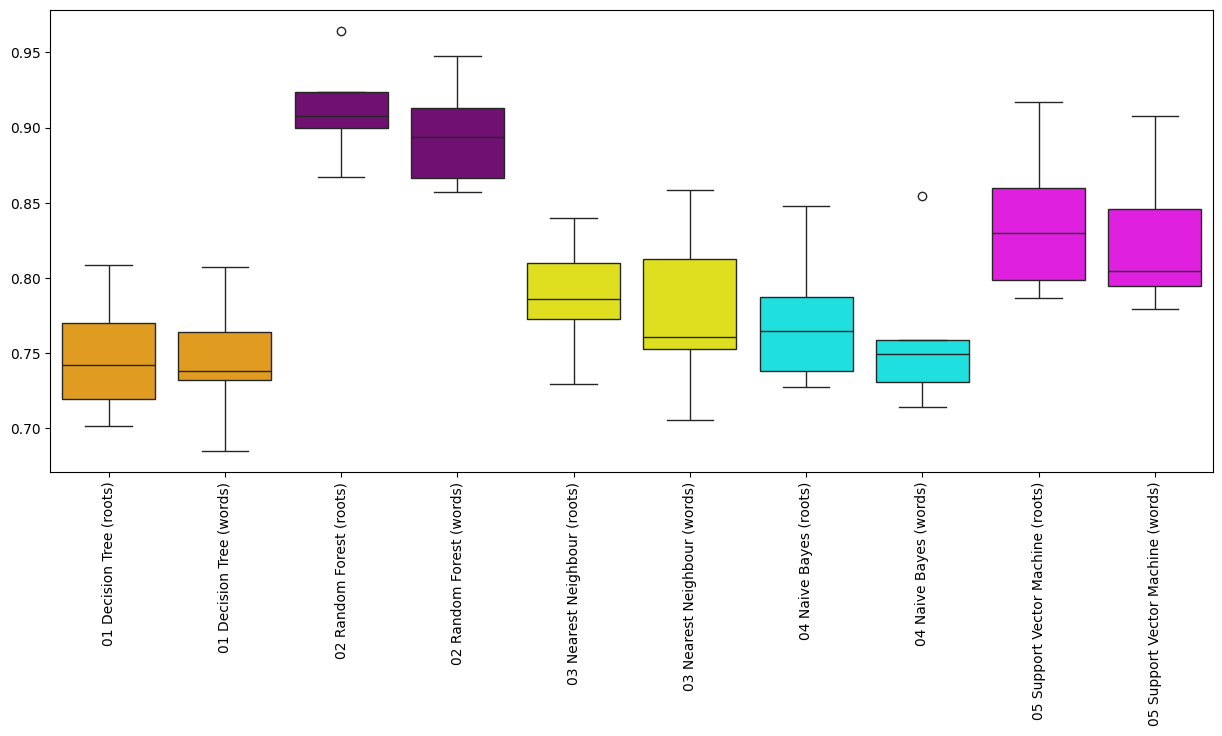

In [121]:
cross_val_scores = cross_val_scores_words.join(cross_val_scores_roots, lsuffix=' (words)', rsuffix=' (roots)')
cross_val_scores = cross_val_scores.loc[:, cross_val_scores.columns.sort_values()]

plt.figure(figsize=(15,6))

colors = ["orange", 
          "purple",
          "yellow",
          "cyan",
          "magenta"]

colors = [colors[i] for i in range(len(colors)) for _ in range(2)]

sns.boxplot(cross_val_scores.loc[['min', '25%', '50%', '75%', 'max'], :], palette=colors)
plt.xticks(rotation=90)

plt.show()

De la comparacion salen siguientes conclusiones:
+ el modelo de **random forest** demuestra mejores resultados de prediccion con los datos de train tanto para las palabras completas como para sus raices
+ segundo mejor resultado pertenece la modelo **Support Vector Machine**
+ los conjuntos de palabras muestran resultados parecidos con el conjunto de raices de palabras desepmeñando un poco mejor

Prosigamos a la prueba con datos de test con **el subconjunto de raices de palabras** y los modelos **random forest** y **Support Vector Machine**.

### Fine-tuning

In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define hyperparameter grids for each model
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    #'max_depth': [3, 5, 10],
    'max_features': ['sqrt', 'log2', 0.2, 0.3, 0.5],  # Example of fixed feature proportion
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 5, 10],
}

svm_param_grid = {
    # Range of values (e.g., 0.001, 0.01, 0.1, 1, 10, 100): It's common to try a range of C values that span several orders of magnitude. This allows you to explore both low and high regularization strengths.
    'C': [0.01, 0.1, 1, 10, 100],
    #'kernel': ['linear', 'rbf'],  # Example with linear and RBF kernels
    #'gamma': [0.1, 1, 10],  # Only used with RBF kernel
}

# Define the models
rf_model = RandomForestClassifier()
svm_model = SVC()

# Create GridSearchCV objects using 'scoring' parameter
scoring = {'accuracy': accuracy_score}  # Use accuracy_score for accuracy

rf_cv = GridSearchCV(rf_model, param_grid=rf_param_grid, cv=5, scoring='accuracy')
svm_cv = GridSearchCV(svm_model, param_grid=svm_param_grid, cv=5, scoring='accuracy')


# Fit the GridSearchCV objects
rf_cv.fit(X_train_scaled, y_train)
svm_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [128]:
# Print the best parameters and scores
print("Best Random Forest Parameters:", rf_cv.best_params_)
print("Best Random Forest Accuracy:", rf_cv.best_score_)
print("Best SVM Parameters:", svm_cv.best_params_)
print("Best SVM Accuracy:", svm_cv.best_score_)

# Use the best models for prediction (optional)
best_rf_model = rf_cv.best_estimator_
best_svm_model = svm_cv.best_estimator_

Best Random Forest Parameters: {'max_features': 'sqrt', 'n_estimators': 500}
Best Random Forest Accuracy: 0.8418803418803419
Best SVM Parameters: {'C': 10}
Best SVM Accuracy: 0.7598290598290598


### Comparacion de mejores modelos con los datos de test

#### Modelo random forest

In [129]:
y_test_predictions = best_rf_model.predict(X_test_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_test_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_test_predictions))

Accuracy: 0.8122866894197952
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       172
           1       0.75      0.81      0.78       121

    accuracy                           0.81       293
   macro avg       0.81      0.81      0.81       293
weighted avg       0.82      0.81      0.81       293



In [130]:
test_contingency = pd.crosstab(y_test, y_test_predictions, rownames=['True Label'], colnames=['Predicted Label'])
test_contingency

Predicted Label,0,1
True Label,,
0,140,32
1,23,98


#### Modelo Support Vector Machine

In [131]:
y_test_predictions = best_svm_model.predict(X_test_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_test_predictions)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_test_predictions))

Accuracy: 0.7372013651877133
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       172
           1       0.69      0.65      0.67       121

    accuracy                           0.74       293
   macro avg       0.73      0.72      0.73       293
weighted avg       0.74      0.74      0.74       293



In [132]:
test_contingency = pd.crosstab(y_test, y_test_predictions, rownames=['True Label'], colnames=['Predicted Label'])
test_contingency

Predicted Label,0,1
True Label,,
0,137,35
1,42,79


#### Elejimos el mejor modelo

Segun los resultados de la prueba con datos de test, **el modelo random forest sigue demostrando mejores resultados de precision**: 0.8123 contra 0.7372. respectivamente.
Utilicemos los resultados obtenidos con este modelo para llegar a conclusiones definitivas para el negocio de las bodegas.

### Conclusiones

El modelo elejido da la importancia a palabras con ciertas raices para clasificar una bodega como punto de enoturismo. Analicemos las raices de palabras que mas importancia han obtenido segun el modelo.

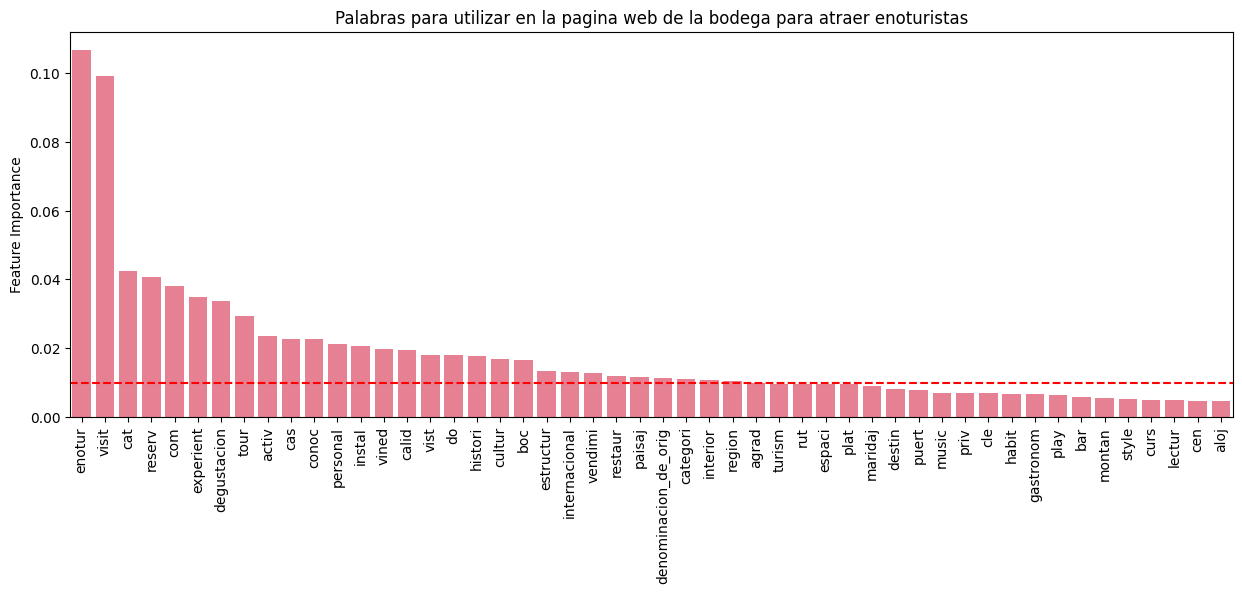

In [133]:
# Obtener la importancia de las características
importance = best_rf_model.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
feature_importance_df = pd.DataFrame(importance, index=X_test.columns, columns=['Importance'])
feature_importance_df.index = feature_importance_df.index.str.replace('kwstems_es_', '')

plt.figure(figsize=(15,5))
sns.barplot(data=feature_importance_df.sort_values('Importance', ascending=False).head(50).reset_index(), x='index', y='Importance')

feature_importance_mean = feature_importance_df['Importance'].mean()
plt.axhline(y=feature_importance_mean, color='red', linestyle='--')

plt.xticks(rotation=90)
plt.title("Palabras para utilizar en la pagina web de la bodega para atraer enoturistas")
plt.xlabel(None)
plt.ylabel("Feature Importance")
plt.show()

| Raiz de la palabra | Palabras derivadas del raiz    |
|--------------------|-----------------------------|
| enotur             | enoturismo, enoturista      |
| visit              | visita, visitante           |
| cat                | cata, catador               |
| reserv             | reserva, reservado          |
| com                | comarca, comarcal           |
| degustacion        | degustación, degustaciones  |
| tour               | tour, tour enológico        |
| personal           | personalizar, personalizado |
| experient          | experiencia, experiencias   |
| vined              | viñedo, viñedos             |
| calid              | calidad, calidades          |
| cas                | caserío, casero             |
| do                 | denominación de origen, DO  |
| activ              | actividad, actividades      |
| histori            | historia, histórico         |
| conoc              | conocimiento, conocedor     |
| boc                | bodega, bodegas             |
| vist               | vista, vistas panorámicas   |
| instal             | instalación, instalaciones  |
| cultur             | cultura, cultural           |
| vendimi            | vendimia, vendimiar         |
| estructur          | estructura, estructural     |
